In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
%matplotlib inline


In [2]:
corners_found_dir='output_images/couners_found/'

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, add object points, image points
    if ret == True:
        
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        image_name = os.path.split(fname)[1]
        cv2.drawChessboardCorners(img, (nx ,ny), corners, ret)
        write_name = corners_found_dir + image_name
        cv2.imwrite(write_name, img)
        print("Success to find corners:", write_name)

cv2.destroyAllWindows()

Success to find corners: output_images/couners_found/calibration10.jpg
Success to find corners: output_images/couners_found/calibration11.jpg
Success to find corners: output_images/couners_found/calibration12.jpg
Success to find corners: output_images/couners_found/calibration13.jpg
Success to find corners: output_images/couners_found/calibration14.jpg
Success to find corners: output_images/couners_found/calibration15.jpg
Success to find corners: output_images/couners_found/calibration16.jpg
Success to find corners: output_images/couners_found/calibration17.jpg
Success to find corners: output_images/couners_found/calibration18.jpg
Success to find corners: output_images/couners_found/calibration19.jpg
Success to find corners: output_images/couners_found/calibration2.jpg
Success to find corners: output_images/couners_found/calibration20.jpg
Success to find corners: output_images/couners_found/calibration3.jpg
Success to find corners: output_images/couners_found/calibration6.jpg
Success t

In [3]:
# Save camera distortion
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist_pickle.p", "wb" ) )

In [4]:
# Check undistorted images
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

undistorted_dir='output_images/undistorted/'

images = glob.glob('camera_cal/calibration*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image_name=os.path.split(fname)[1]
    write_name = undistorted_dir+image_name
    cv2.imwrite(write_name,dst)
    print("Save undistorted image:", write_name)
cv2.destroyAllWindows()

test_images = glob.glob('test_images/*.jpg')

for idx, fname in enumerate(test_images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image_name=os.path.split(fname)[1]
    write_name = undistorted_dir+image_name
    cv2.imwrite(write_name,dst)
    print("Save undistorted image:", write_name)
cv2.destroyAllWindows()

Save undistorted image: output_images/undistorted/calibration1.jpg
Save undistorted image: output_images/undistorted/calibration10.jpg
Save undistorted image: output_images/undistorted/calibration11.jpg
Save undistorted image: output_images/undistorted/calibration12.jpg
Save undistorted image: output_images/undistorted/calibration13.jpg
Save undistorted image: output_images/undistorted/calibration14.jpg
Save undistorted image: output_images/undistorted/calibration15.jpg
Save undistorted image: output_images/undistorted/calibration16.jpg
Save undistorted image: output_images/undistorted/calibration17.jpg
Save undistorted image: output_images/undistorted/calibration18.jpg
Save undistorted image: output_images/undistorted/calibration19.jpg
Save undistorted image: output_images/undistorted/calibration2.jpg
Save undistorted image: output_images/undistorted/calibration20.jpg
Save undistorted image: output_images/undistorted/calibration3.jpg
Save undistorted image: output_images/undistorted/c

In [154]:
def undistort(img, mtx, dist):
    undist_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_image

def binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255), l_thresh=(40,255)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    color_binary = np.dstack(( l_binary , sxbinary, s_binary))

    binary = np.zeros_like(sxbinary)
    binary[(l_binary == 1) & (s_binary == 1) | (sxbinary==1)] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            

    return binary, color_binary


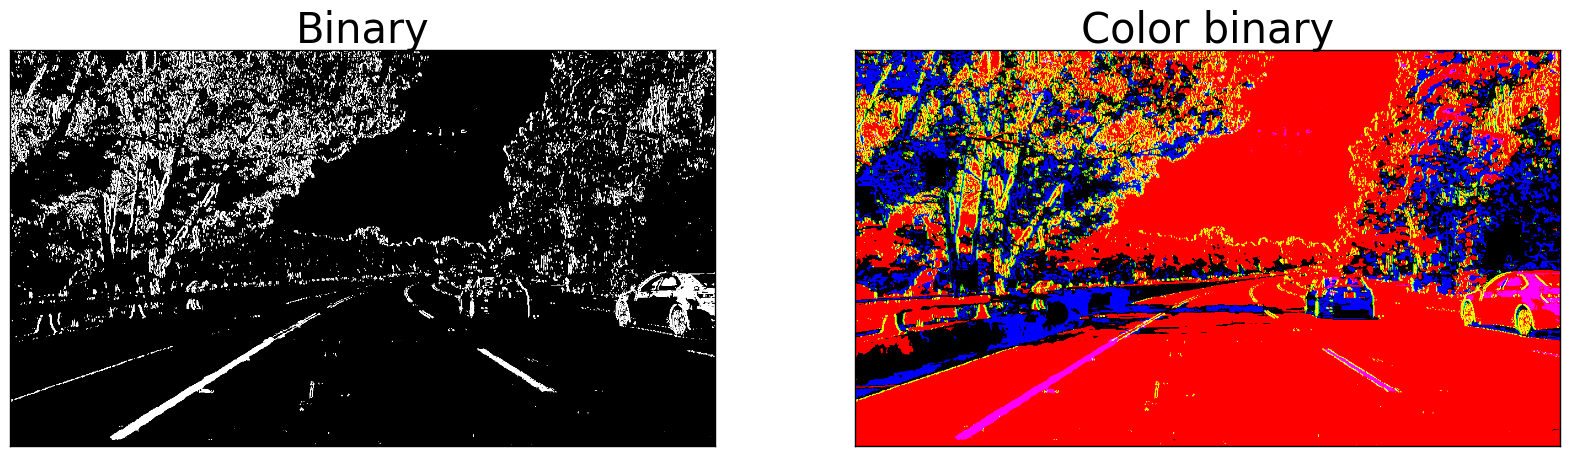

In [155]:
test_images = glob.glob('test_images/test5.jpg')

for idx, fname in enumerate(test_images):
    image = plt.imread(fname)
    undist_image = undistort(image, mtx, dist)
    binary,color = binarize(undist_image)

    # Plot the result
    fig = plt.figure(figsize=(20, 6))
    subplot = fig.add_subplot(1,2,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('Binary', fontsize=30)
    subplot.imshow(binary)

    subplot2 = fig.add_subplot(1,2,2)
    subplot2.set_xticks([])
    subplot2.set_yticks([])
    subplot2.set_title('Color binary', fontsize=30)
    subplot2.imshow(color)
    plt.show()


In [156]:
def warp(img,tobird=True):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    if tobird:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


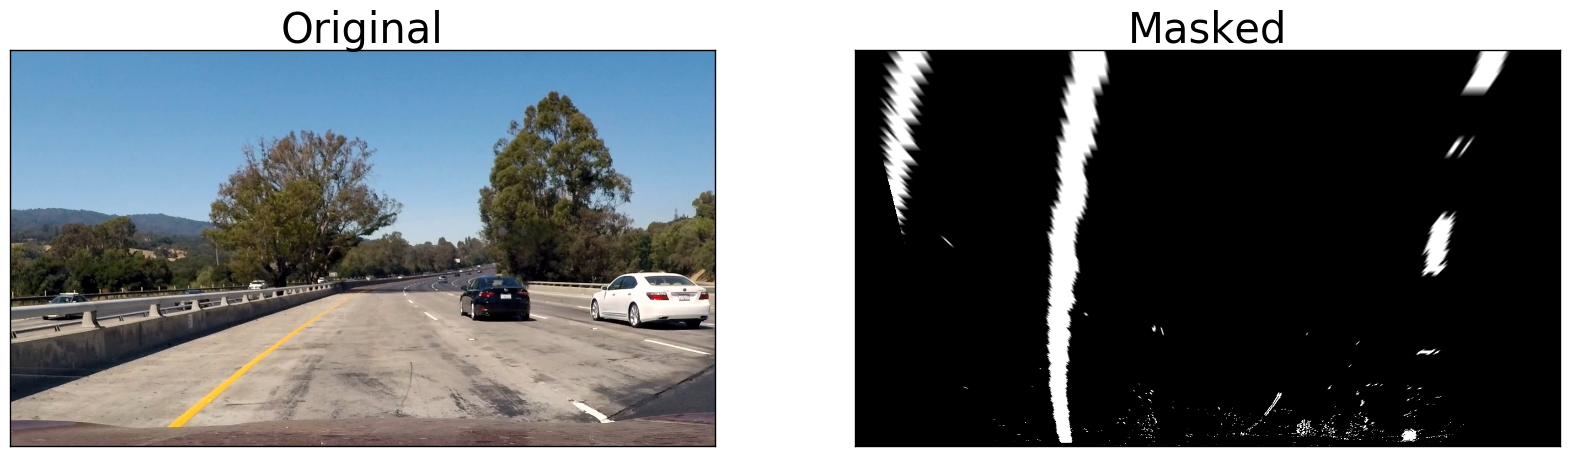

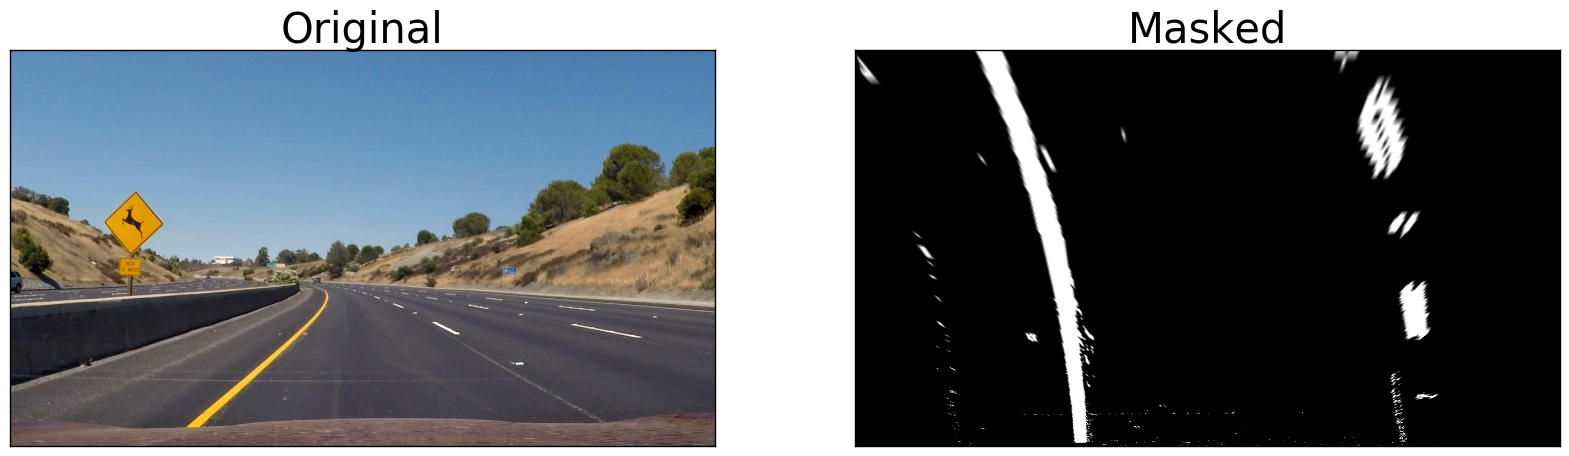

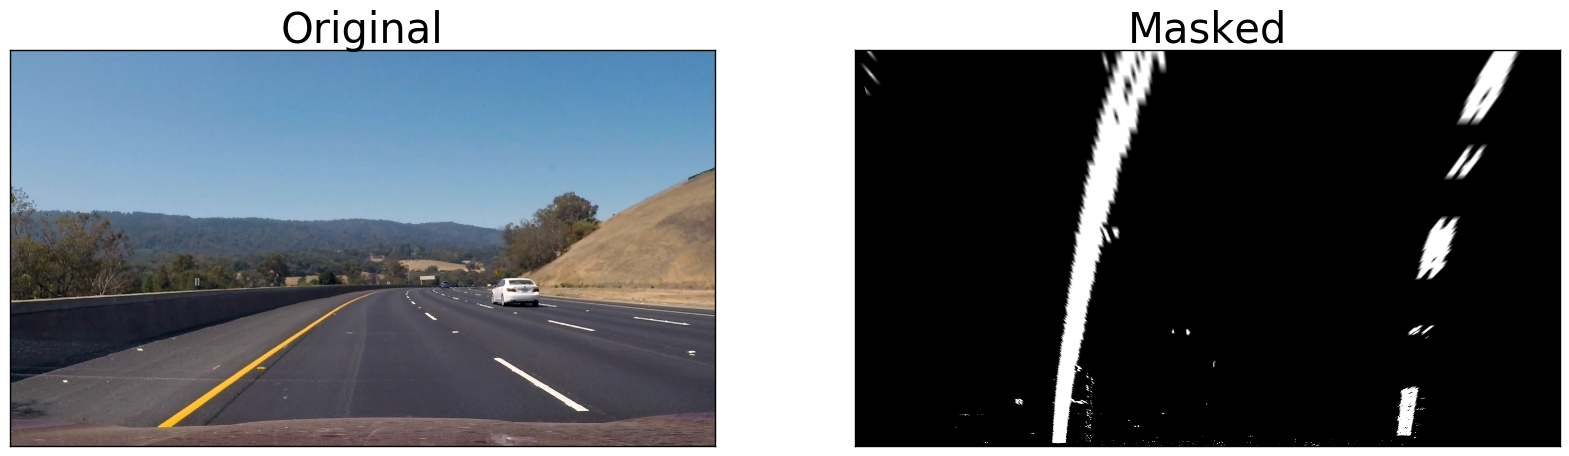

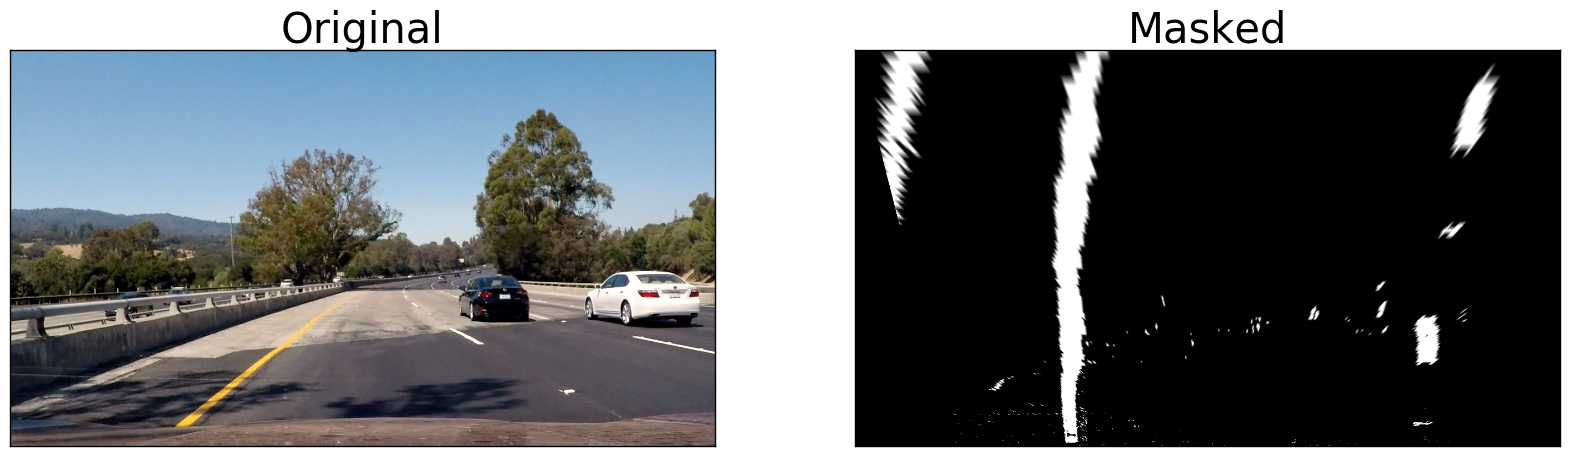

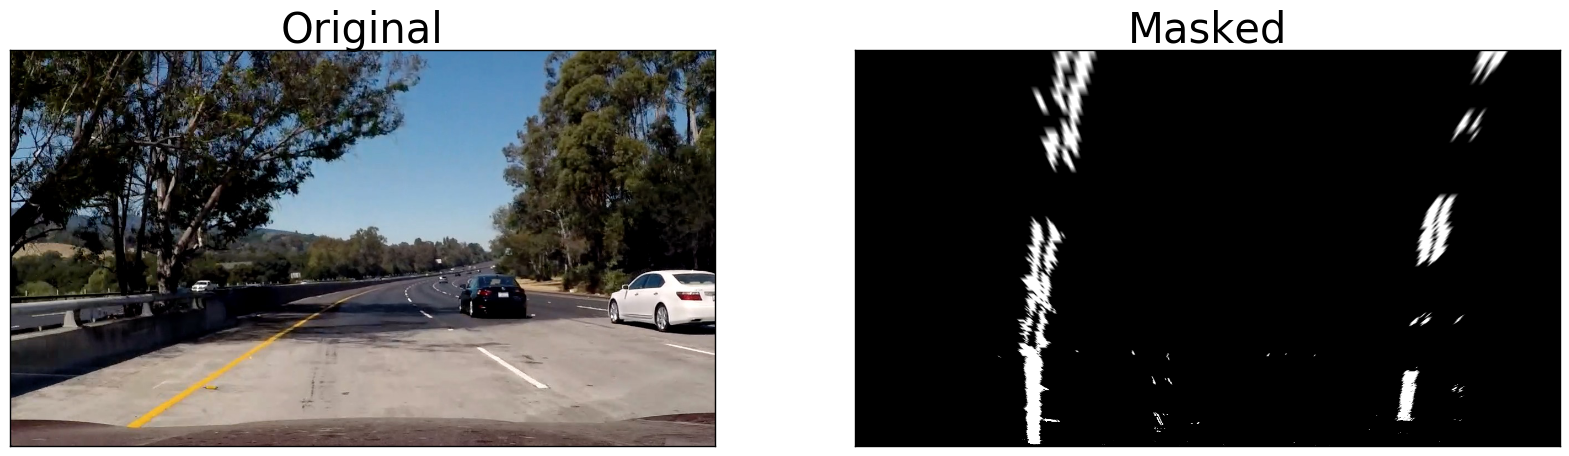

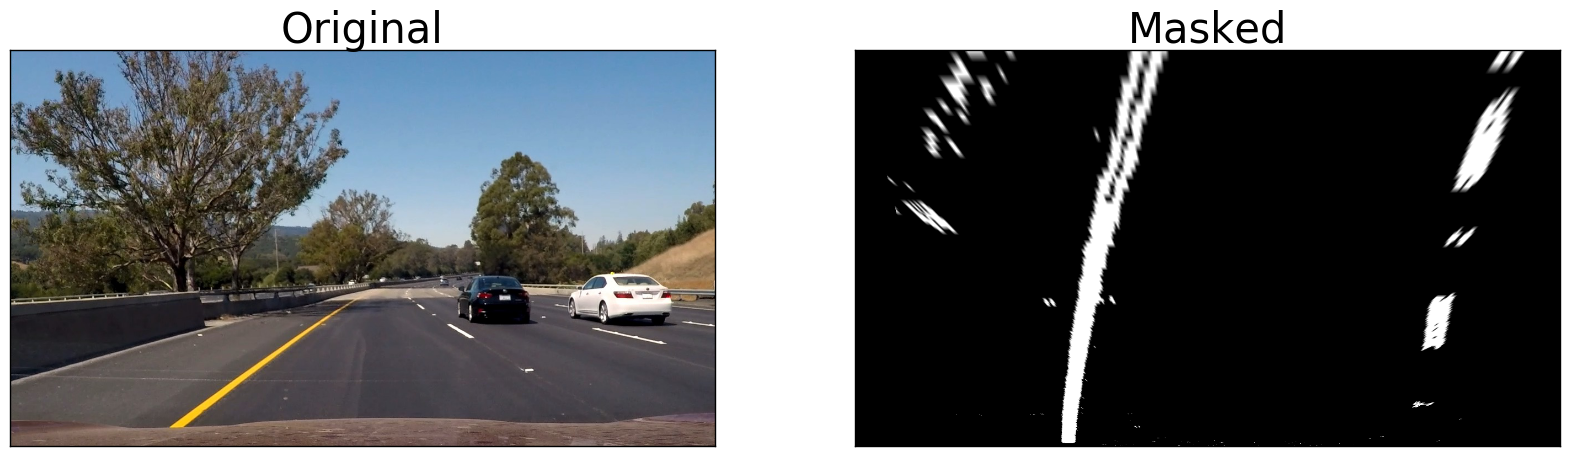

In [157]:
test_images = glob.glob('test_images/test*.jpg')

for idx, fname in enumerate(test_images):
    image = plt.imread(fname)
    undist_image = undistort(image, mtx, dist)
    binary,_ = binarize(undist_image)
    warped,_ = warp(binary)
    masked_image = region_of_interest(warped)

    # Plot the result
    fig = plt.figure(figsize=(20, 6))
    subplot = fig.add_subplot(1,2,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('Original', fontsize=30)
    subplot.imshow(image)

    subplot2 = fig.add_subplot(1,2,2)
    subplot2.set_xticks([])
    subplot2.set_yticks([])
    subplot2.set_title('Masked', fontsize=30)
    subplot2.imshow(masked_image)
    plt.show()


In [91]:
def get_next_window(img,center_point,width):
    """
    input: img,center_point,width
        img: binary 3 channel image
        center_point: center of window
        width: width of window
    
    output: masked,center_point
        masked : a masked image of the same size. mask is a window centered at center_point
        center : the mean ofall pixels found within the window
    """
    
    ny,nx,_ = img.shape
    mask  = np.zeros_like(img)
    if (center_point <= width/2): center_point = width/2
    if (center_point >= nx-width/2): center_point = nx-width/2
    
    left  = center_point - width/2
    right = center_point + width/2
    
    vertices = np.array([[(left,0),(left,ny), (right,ny),(right,0)]], dtype=np.int32)
    ignore_mask_color=(255,255,255)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked = cv2.bitwise_and(mask,img)

    hist = np.sum(masked[:,:,0],axis=0)
    if max(hist>10000):
        center = np.argmax(hist)
    else:
        center = center_point
        
    return masked,center

def lane_from_window(binary,center_point,width):
    n_zones=6
    ny,nx,nc = binary.shape
    zones = binary.reshape(n_zones,-1,nx,nc)
    zones = zones[::-1] # start from the bottom slice
    window,center = get_next_window(zones[0],center_point,width)
   
    for zone in zones[1:]:
        next_window,center = get_next_window(zone,center,width)
        window = np.vstack((next_window,window))
    
    return window

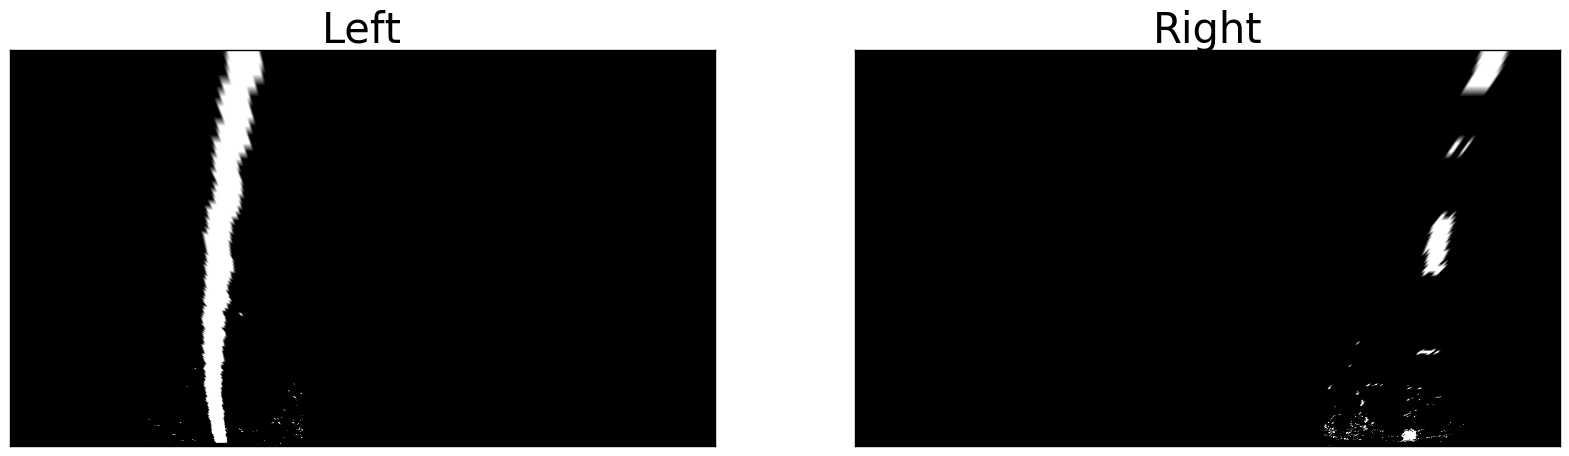

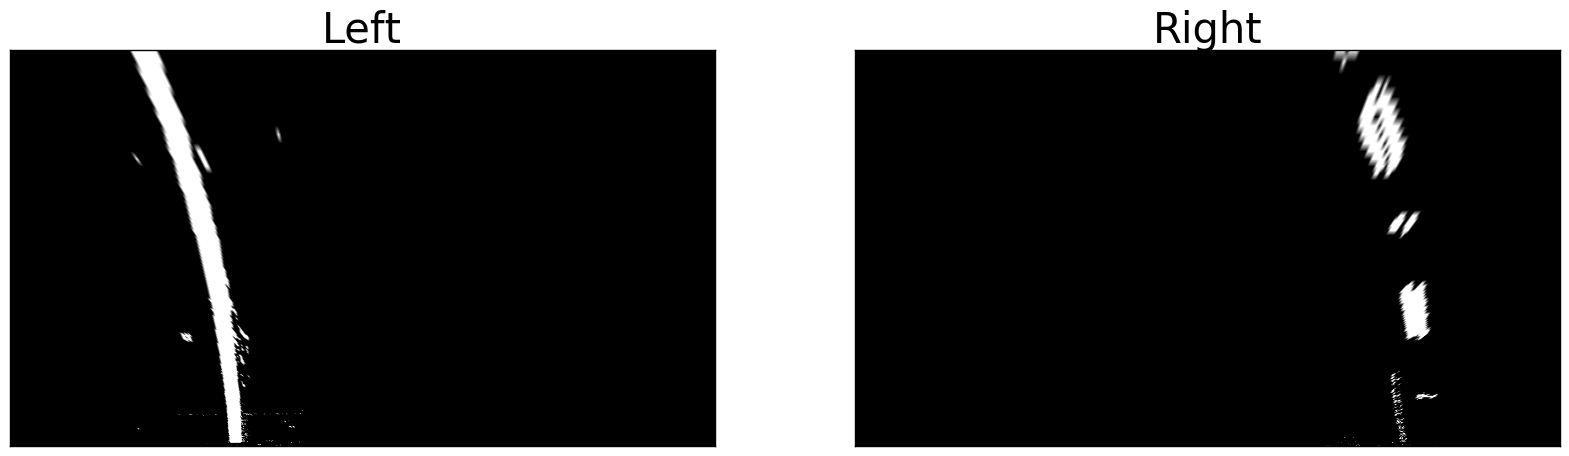

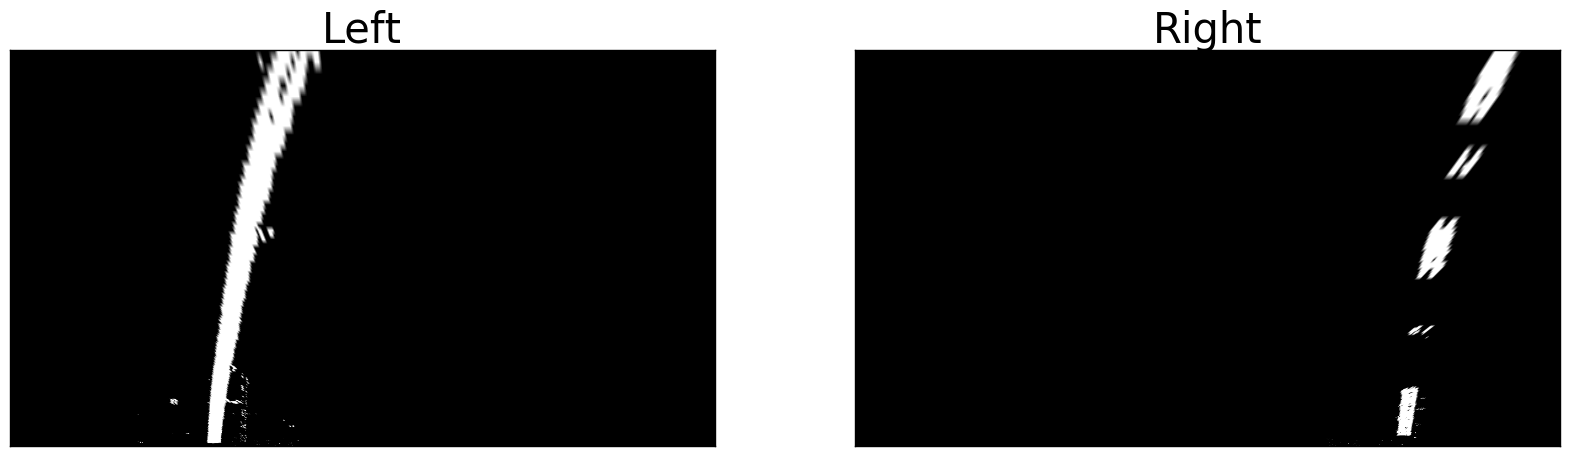

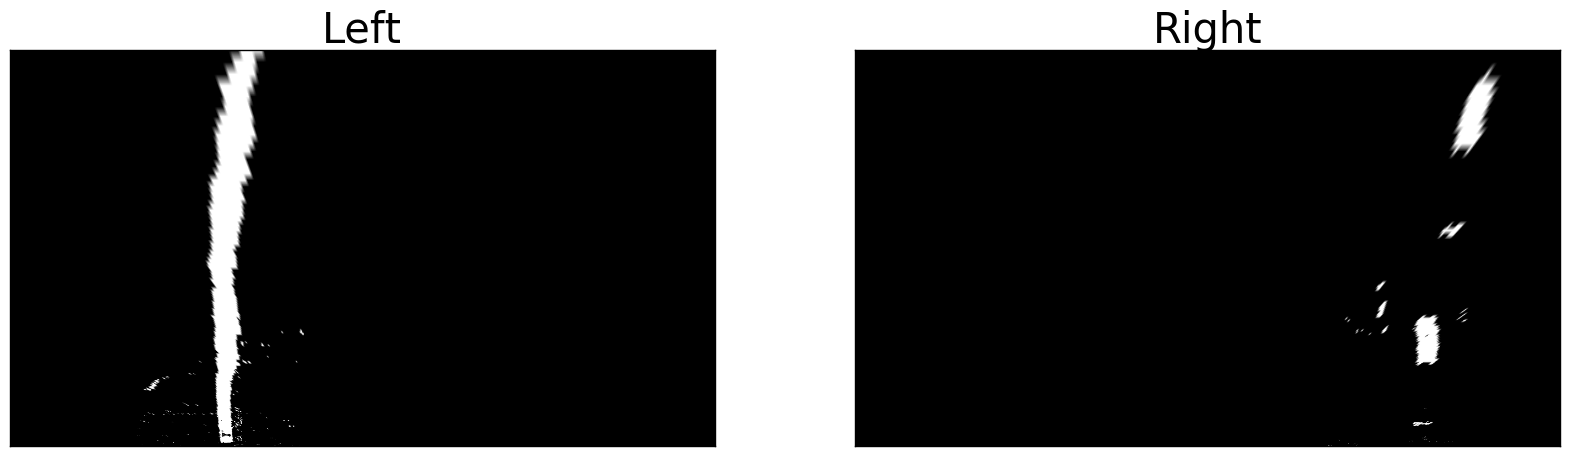

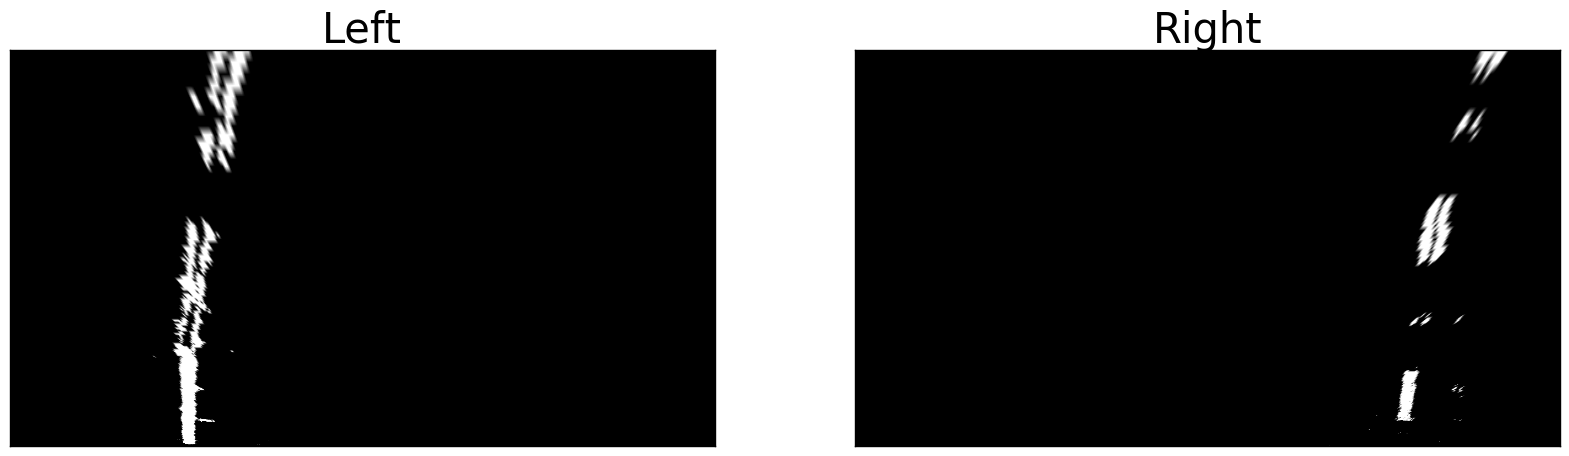

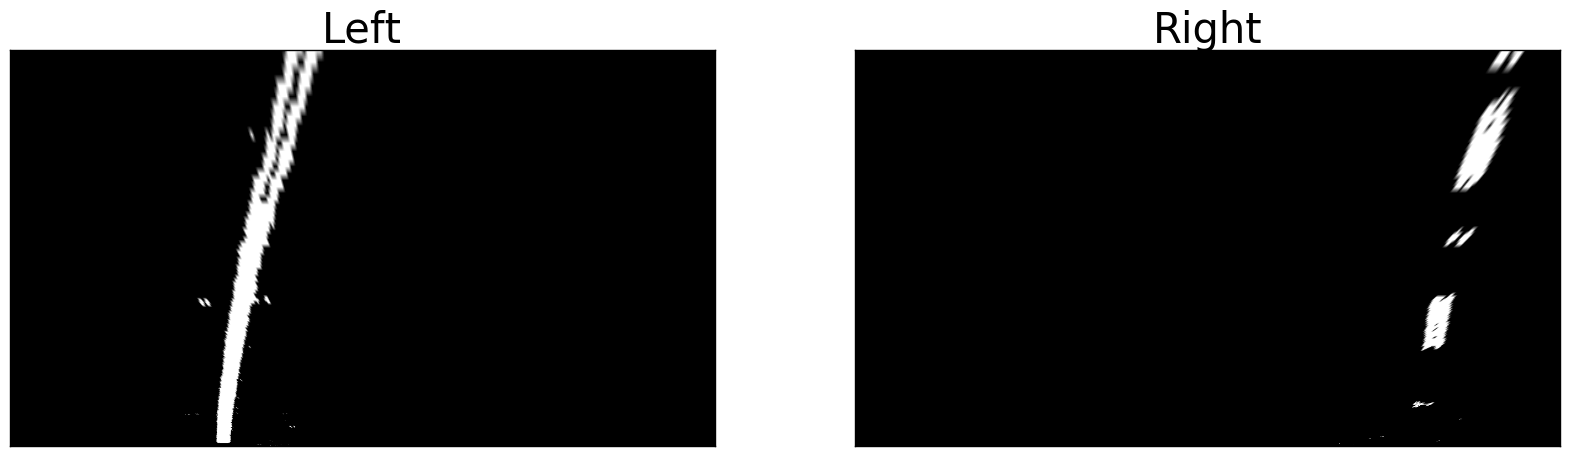

In [160]:
test_images = glob.glob('test_images/test*.jpg')

for idx, fname in enumerate(test_images):
    image = plt.imread(fname)
    undist_image = undistort(image, mtx, dist)
    binary,_ = binarize(undist_image)
    warped,_ = warp(binary)
    masked_image = region_of_interest(warped)

    left_binary = lane_from_window(masked_image,380,300)
    right_binary = lane_from_window(masked_image,1000,300)

    lanes_line_dir='output_images/lane_lines/'

    image_name=os.path.split(fname)[1]

    plt.imsave(lanes_line_dir+'left_'+image_name, left_binary)
    plt.imsave(lanes_line_dir+'right_'+image_name, right_binary)

    # Plot the result
    fig = plt.figure(figsize=(20, 6))
    subplot = fig.add_subplot(1,2,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('Left', fontsize=30)
    subplot.imshow(left_binary)

    subplot2 = fig.add_subplot(1,2,2)
    subplot2.set_xticks([])
    subplot2.set_yticks([])
    subplot2.set_title('Right', fontsize=30)
    subplot2.imshow(right_binary)
    plt.show()


In [161]:
from collections import deque

# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self,n=5):
        # length of queue to store data
        self.n = n
        #number of fits in buffer
        self.n_buffered = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([],maxlen=n)
        #average x values of the fitted line over the last n iterations
        self.avgx = None
        # fit coeffs of the last n fits
        self.recent_fit_coeffs = deque([],maxlen=n)        
        #polynomial coefficients averaged over the last n iterations
        self.avg_fit_coeffs = None  
        # xvals of the most recent fit
        self.current_fit_xvals = [np.array([False])]  
        #polynomial coefficients for the most recent fit
        self.current_fit_coeffs = [np.array([False])]          
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #y values for line fit
        self.fit_yvals = np.linspace(0, 100, num=101)*7.2  # always the same y-range as image
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # origin (pixels) of fitted line at the bottom of the image
        self.line_pos = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 

    def set_current_fit_xvals(self): # 3
        yvals = self.fit_yvals
        self.current_fit_xvals = self.current_fit_coeffs[0]*yvals**2 + self.current_fit_coeffs[1]*yvals + self.current_fit_coeffs[2]
        
    def add_data(self): #8
        self.recent_xfitted.appendleft(self.current_fit_xvals)
        self.recent_fit_coeffs.appendleft(self.current_fit_coeffs)
        assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
        self.n_buffered = len(self.recent_xfitted)
        
    def pop_data(self): # 11   
        if self.n_buffered>0:
            self.recent_xfitted.pop()
            self.recent_fit_coeffs.pop()
            assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
            self.n_buffered = len(self.recent_xfitted)
        
        return self.n_buffered
        
    def set_avgx(self): # 10
        fits = self.recent_xfitted
        if len(fits)>0:
            avg=0
            for fit in fits:
                avg +=np.array(fit)
            avg = avg / len(fits)
            self.avgx = avg
            
    def set_avgcoeffs(self): # 9
        coeffs = self.recent_fit_coeffs
        if len(coeffs)>0:
            avg=0
            for coeff in coeffs:
                avg +=np.array(coeff)
            avg = avg / len(coeffs)
            self.avg_fit_coeffs = avg
    
    def set_allxy(self,lane_candidate): #1
        self.ally,self.allx = (lane_candidate[:,:,0]>254).nonzero()

    def set_current_fit_coeffs(self): # 2
        self.current_fit_coeffs = np.polyfit(self.ally, self.allx, 2)
    
    def get_diffs(self): # 6
        if self.n_buffered>0:
            self.diffs = self.current_fit_coeffs - self.avg_fit_coeffs
        else:
            self.diffs = np.array([0,0,0], dtype='float')                 
            
    def set_radius_of_curvature(self): # 4
        # Define y-value where we want radius of curvature (choose bottom of the image)
        y_eval = max(self.fit_yvals)
        if self.avg_fit_coeffs is not None:
            self.radius_of_curvature = ((1 + (2*self.avg_fit_coeffs[0]*y_eval + self.avg_fit_coeffs[1])**2)**1.5) \
                             /np.absolute(2*self.avg_fit_coeffs[0])
                        
            
    def set_line_base_pos(self): # 5
        y_eval = max(self.fit_yvals)
        self.line_pos = self.current_fit_coeffs[0]*y_eval**2 \
                        +self.current_fit_coeffs[1]*y_eval \
                        + self.current_fit_coeffs[2]
        basepos = 640
        
        self.line_base_pos = (self.line_pos - basepos)*3.7/600.0 # 3.7 meters is about 600 pixels in the x direction

    # here come sanity checks of the computed metrics
    def accept_lane(self): # 7
        flag = True
        maxdist = 2.8  # distance in meters from the lane
        if(abs(self.line_base_pos) > maxdist ):
            print('lane too far away')
            flag  = False        
        if(self.n_buffered > 0):
            relative_delta = self.diffs / self.avg_fit_coeffs
            # allow maximally this percentage of variation in the fit coefficients from frame to frame
            if not (abs(relative_delta)<np.array([0.7,0.5,0.15])).all():
                print('fit coeffs too far off [%]',relative_delta)
                flag=False
                
        return flag
    
    def update(self,lane):
        self.set_allxy(lane)
        self.set_current_fit_coeffs()
        self.set_current_fit_xvals()
        self.set_radius_of_curvature()
        self.set_line_base_pos()
        self.get_diffs()
        if self.accept_lane():
            self.detected=True
            self.add_data()
            self.set_avgx()
            self.set_avgcoeffs()            
        else:
            self.detected=False            
            self.pop_data()
            if self.n_buffered>0:
                self.set_avgx()
                self.set_avgcoeffs()
                    
        return self.detected,self.n_buffered
    


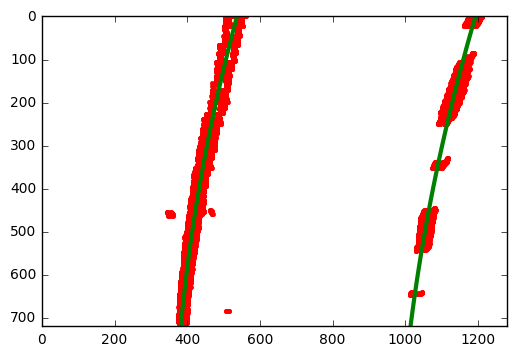

In [162]:
test_left=Line()
test_right=Line()

detected_l,n_buffered_left = test_left.update(left_binary)
detected_r,n_buffered_right = test_right.update(right_binary)

leftx = test_left.allx
left_fitx = test_left.current_fit_xvals
yvals_l = test_left.ally

rightx = test_right.allx
right_fitx = test_right.current_fit_xvals
yvals_r = test_right.ally

yvals = test_left.fit_yvals

plt.plot(rightx, yvals_r, '.', color='red')
plt.plot(right_fitx, yvals, color='green', linewidth=3)

plt.plot(leftx, yvals_l, '.', color='red')
plt.plot(left_fitx, yvals, color='green', linewidth=3)

plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.gca().invert_yaxis()
plt.show()


In [149]:
def find_lines_base(img):
    img_half=img[img.shape[0]/2:,:,0]
    histogram = np.sum(img_half, axis=0)
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    lines_base = np.array([leftx_base, rightx_base])
    return lines_base

def get_binary_lane_image(img,line,window_center,width=300):
    if line.detected:
        window_center=line.line_pos
    else:
        lines_base = find_lines_base(img)
            
        line_index = np.argmin(abs(lines_base-window_center)) # choose left or right index
        window_center  = lines_base[line_index]
    
    lane_binary = lane_from_window(img, window_center, width)
    return lane_binary 


In [150]:
def project_lane_lines(img,left_fitx,right_fitx,yvals):
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    unwarp,Minv = warp(img,tobird=False)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    undist = undistort(img, mtx, dist)    
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [147]:
def process_image(img):
    global left
    global right
    undist = undistort(img, mtx, dist)
    binary,_  = binarize(undist)
    warped,_  = warp(binary)
    warped_binary = region_of_interest(warped)
    
    window_center_l = 340
    if left.detected:
        window_center_l = left.line_pos        
    left_binary = get_binary_lane_image(warped_binary,left,window_center_l,width=300)
    
    window_center_r = 940
    if right.detected:
        window_center_r = right.line_pos        
    right_binary = get_binary_lane_image(warped_binary,right,window_center_r,width=300)
    
    detected_l,n_buffered_left = left.update(left_binary)
    detected_r,n_buffered_right = right.update(right_binary)    
    
    left_fitx = left.avgx
    right_fitx = right.avgx
    yvals = left.fit_yvals
    lane_width = 3.7
    off_center = -100*round(0.5*(right.line_base_pos-lane_width/2) +  0.5*(abs(left.line_base_pos)-lane_width/2),2)

    result = project_lane_lines(img,left_fitx,right_fitx,yvals)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    str1 = str('distance from center: '+str(off_center)+'cm')
    cv2.putText(result,str1,(100,100), font, 2,(255,255,255),2,cv2.LINE_AA)
    if left.radius_of_curvature and right.radius_of_curvature:
        curvature = 0.5*(round(right.radius_of_curvature/1000,1) + round(left.radius_of_curvature/1000,1))
        str2 = str('radius of curvature: '+str(curvature)+'km')
        cv2.putText(result,str2,(200,200), font, 2,(255,255,255),2,cv2.LINE_AA)    
    
    return result

/Users/hideto.kimura/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


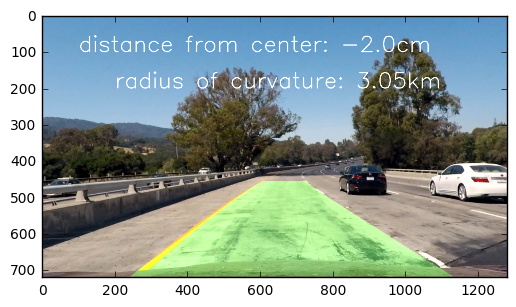

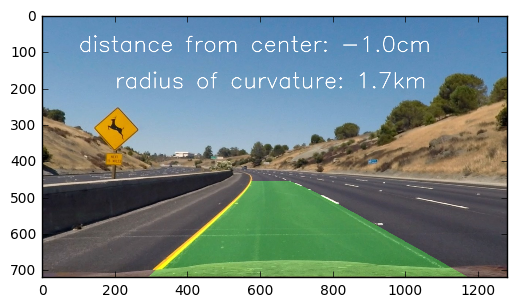

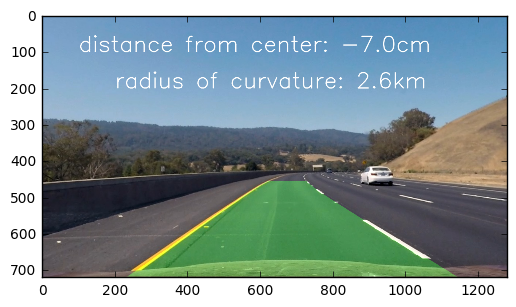

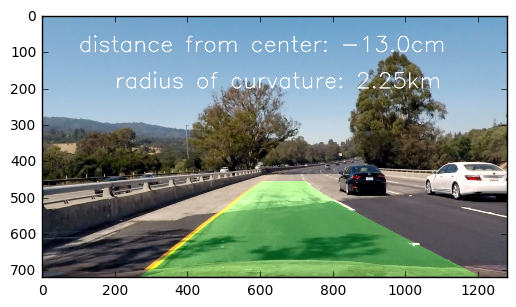

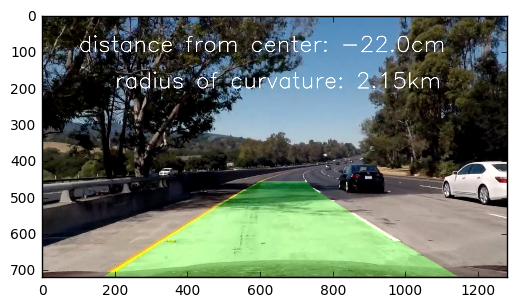

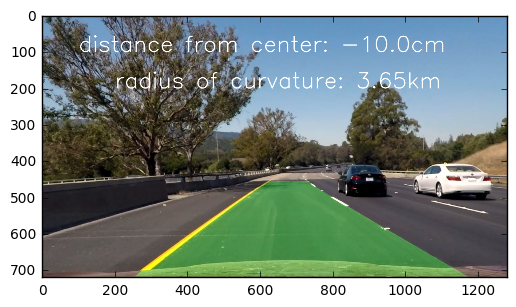

In [163]:
test_images = glob.glob('test_images/test*.jpg')

for idx, fname in enumerate(test_images):
    left = Line(7)
    right = Line(7)

    new_image = plt.imread(fname)
    result = process_image(new_image)
    result = process_image(new_image)
    plt.figure()
    plt.imshow(result)
    plt.show()
    

In [164]:
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

left = Line(7)
right = Line(7)

out_dir='./'
output = out_dir+'processed_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


  1%|          | 14/1261 [00:04<06:17,  3.31it/s]

fit coeffs too far off [%] [ 0.97479316  0.29954646 -0.01559499]


  1%|          | 15/1261 [00:04<06:30,  3.19it/s]

fit coeffs too far off [%] [ 0.95067814  0.36230205 -0.03657279]


  1%|▏         | 16/1261 [00:05<06:45,  3.07it/s]

fit coeffs too far off [%] [ 0.83406569  0.36130691 -0.0494339 ]


  6%|▌         | 74/1261 [00:22<06:04,  3.26it/s]

fit coeffs too far off [%] [ 0.85768444  0.28897794 -0.01218818]


  7%|▋         | 84/1261 [00:26<07:30,  2.61it/s]

fit coeffs too far off [%] [-0.91797737 -0.46489173  0.04298614]


  9%|▉         | 114/1261 [00:37<06:05,  3.14it/s]

fit coeffs too far off [%] [ 0.90249444  0.506914   -0.02998124]


 12%|█▏        | 148/1261 [00:48<05:37,  3.30it/s]

fit coeffs too far off [%] [ 0.94011964  0.43469849 -0.04254145]


 12%|█▏        | 149/1261 [00:48<05:49,  3.18it/s]

fit coeffs too far off [%] [ 0.99076993  0.46390333 -0.04390299]


 12%|█▏        | 150/1261 [00:48<05:55,  3.12it/s]

fit coeffs too far off [%] [ 0.74489922  0.32399053 -0.02591897]


 14%|█▎        | 171/1261 [00:55<05:50,  3.11it/s]

fit coeffs too far off [%] [ 0.73850129  0.17797347  0.00806323]


 14%|█▎        | 172/1261 [00:56<05:54,  3.07it/s]

fit coeffs too far off [%] [ 1.08839752  0.31854008 -0.00242244]


 14%|█▎        | 173/1261 [00:56<06:02,  3.00it/s]

fit coeffs too far off [%] [ 1.15899749  0.41180227 -0.02061657]


 14%|█▍        | 174/1261 [00:56<05:58,  3.03it/s]

fit coeffs too far off [%] [ 1.68674732  0.72925279 -0.06285984]


 14%|█▍        | 175/1261 [00:57<05:57,  3.04it/s]

fit coeffs too far off [%] [ 1.68659624  0.82074964 -0.08245682]


 14%|█▍        | 176/1261 [00:57<05:59,  3.02it/s]

fit coeffs too far off [%] [ 1.44206625  0.78453072 -0.0878501 ]


 14%|█▍        | 177/1261 [00:57<06:04,  2.97it/s]

fit coeffs too far off [%] [ 1.24835978  0.66113258 -0.06651984]


 24%|██▍       | 305/1261 [01:38<04:51,  3.28it/s]

fit coeffs too far off [%] [-1.63722069 -0.71310995  0.03037542]


 24%|██▍       | 306/1261 [01:38<04:56,  3.22it/s]

fit coeffs too far off [%] [-1.62991706 -0.65000107  0.01522787]


 24%|██▍       | 307/1261 [01:38<05:06,  3.11it/s]

fit coeffs too far off [%] [-1.23443605 -0.55644134  0.02222918]


 25%|██▍       | 311/1261 [01:40<04:57,  3.19it/s]

fit coeffs too far off [%] [-0.89326711 -0.34101771  0.00548795]


 25%|██▍       | 312/1261 [01:40<05:11,  3.05it/s]

fit coeffs too far off [%] [-0.83629195 -0.35077221  0.00847025]


 25%|██▍       | 313/1261 [01:40<05:21,  2.95it/s]

fit coeffs too far off [%] [-0.70970005 -0.48289906  0.11351642]


 25%|██▍       | 314/1261 [01:41<05:25,  2.91it/s]

fit coeffs too far off [%] [-0.91015954 -0.51660118  0.10478954]
fit coeffs too far off [%] [-0.80988022 -0.34574074  0.00944792]


 25%|██▍       | 315/1261 [01:41<05:28,  2.88it/s]

fit coeffs too far off [%] [-0.79431921 -0.48766999  0.09426273]


 25%|██▌       | 316/1261 [01:41<05:36,  2.81it/s]

fit coeffs too far off [%] [-1.12599175 -0.53863081  0.08419606]


 25%|██▌       | 317/1261 [01:42<05:31,  2.84it/s]

fit coeffs too far off [%] [-0.7993383  -0.39533757  0.06289768]


 25%|██▌       | 318/1261 [01:42<05:39,  2.78it/s]

fit coeffs too far off [%] [-0.86505672 -0.51715495  0.08726076]
fit coeffs too far off [%] [ 2.05483319  0.27589926  0.00265589]


 25%|██▌       | 319/1261 [01:42<05:35,  2.81it/s]

fit coeffs too far off [%] [-1.16405645 -0.53968037  0.07912757]
fit coeffs too far off [%] [ 3.22578781  0.45843065  0.00658696]


 25%|██▌       | 320/1261 [01:43<05:33,  2.82it/s]

fit coeffs too far off [%] [  2.77311919e+00   4.80593038e-01  -1.49715942e-03]


 25%|██▌       | 321/1261 [01:43<05:27,  2.87it/s]

fit coeffs too far off [%] [ 2.17125627  0.29118869  0.0088526 ]


 26%|██▌       | 322/1261 [01:44<05:27,  2.86it/s]

fit coeffs too far off [%] [ 1.34240458  0.26996998  0.00354077]


 26%|██▌       | 323/1261 [01:44<05:27,  2.86it/s]

fit coeffs too far off [%] [  1.96839075e+00   5.21891180e-01  -1.62676364e-03]


 26%|██▌       | 329/1261 [01:46<04:53,  3.18it/s]

fit coeffs too far off [%] [-0.26652109  0.88555686 -0.03433168]


 26%|██▌       | 330/1261 [01:46<04:57,  3.13it/s]

fit coeffs too far off [%] [-0.61436608  0.65658027 -0.01491655]
fit coeffs too far off [%] [-1.1772565  -0.67991493  0.017027  ]


 26%|██▌       | 331/1261 [01:46<05:02,  3.08it/s]

fit coeffs too far off [%] [ -1.02183797e+00   5.68161822e-01  -4.85329393e-04]


 26%|██▋       | 332/1261 [01:47<05:07,  3.02it/s]

fit coeffs too far off [%] [-1.24369823  0.14688742  0.02850634]


 26%|██▋       | 333/1261 [01:47<05:03,  3.06it/s]

fit coeffs too far off [%] [-0.61079661 -0.93411204  0.05017767]
fit coeffs too far off [%] [-0.71058844 -0.18518699 -0.01416033]


 26%|██▋       | 334/1261 [01:47<05:04,  3.04it/s]

fit coeffs too far off [%] [-1.1235744  -0.23543586  0.04395779]
fit coeffs too far off [%] [-0.83467246 -0.32001353 -0.00969554]


 27%|██▋       | 335/1261 [01:48<05:03,  3.05it/s]

fit coeffs too far off [%] [-1.20707249 -0.0526231   0.04243086]
fit coeffs too far off [%] [-0.82288526 -0.26847981 -0.01208577]


 27%|██▋       | 336/1261 [01:48<05:12,  2.96it/s]

fit coeffs too far off [%] [-0.70950993 -0.49165004  0.00943954]


 27%|██▋       | 337/1261 [01:48<05:09,  2.98it/s]

fit coeffs too far off [%] [ 1.59222099 -0.12020295  0.0022197 ]
fit coeffs too far off [%] [-1.16643963 -0.8436177   0.01818616]


 27%|██▋       | 338/1261 [01:49<05:08,  2.99it/s]

fit coeffs too far off [%] [-0.93953153 -0.78762431  0.02993167]


 27%|██▋       | 339/1261 [01:49<05:04,  3.03it/s]

fit coeffs too far off [%] [-0.71428268 -0.67358828  0.03471307]


 27%|██▋       | 340/1261 [01:49<05:09,  2.97it/s]

fit coeffs too far off [%] [ 1.81199236 -1.63598495  0.03405315]


 27%|██▋       | 341/1261 [01:50<05:06,  3.00it/s]

fit coeffs too far off [%] [ 1.199223   -1.57440077  0.03012978]
fit coeffs too far off [%] [ -5.65855623e+00  -6.59608458e-01   5.56236859e-03]


 27%|██▋       | 343/1261 [01:50<05:08,  2.98it/s]

fit coeffs too far off [%] [-0.10312069 -0.54913155 -0.01660703]


 27%|██▋       | 345/1261 [01:51<04:59,  3.06it/s]

fit coeffs too far off [%] [-0.14822942 -1.72450486 -0.0106996 ]


 27%|██▋       | 346/1261 [01:51<05:02,  3.03it/s]

fit coeffs too far off [%] [-0.44755076 -0.53704019  0.02055087]


 28%|██▊       | 348/1261 [01:52<04:58,  3.06it/s]

fit coeffs too far off [%] [-0.59616467  0.81572782 -0.01362104]
fit coeffs too far off [%] [-0.63103643 -0.67828164  0.01970761]


 28%|██▊       | 349/1261 [01:52<04:57,  3.07it/s]

fit coeffs too far off [%] [-2.30806634  1.29652597 -0.01196181]
fit coeffs too far off [%] [-1.02957078 -0.81071765  0.01323963]


 28%|██▊       | 350/1261 [01:53<04:57,  3.06it/s]

fit coeffs too far off [%] [-1.05216935 -1.03251254  0.02012738]


 28%|██▊       | 351/1261 [01:53<04:54,  3.08it/s]

fit coeffs too far off [%] [  1.45582930e+00   2.58181494e-01  -1.19785933e-03]
fit coeffs too far off [%] [-0.56138387 -0.66388853  0.01338252]


 28%|██▊       | 353/1261 [01:54<04:50,  3.13it/s]

fit coeffs too far off [%] [  1.09802847e+01   4.13096968e+00   6.98226483e-03]


 28%|██▊       | 355/1261 [01:54<04:56,  3.05it/s]

fit coeffs too far off [%] [-0.3688848   0.50104555  0.00518292]


 28%|██▊       | 357/1261 [01:55<04:56,  3.05it/s]

fit coeffs too far off [%] [  7.34798856 -19.74776094  -0.01974969]


 28%|██▊       | 359/1261 [01:56<04:49,  3.11it/s]

fit coeffs too far off [%] [-1.02335891 -0.60574431  0.03842995]


 29%|██▊       | 360/1261 [01:56<05:08,  2.92it/s]

fit coeffs too far off [%] [-1.17566021 -0.63806748  0.03413934]


 29%|██▊       | 361/1261 [01:56<05:05,  2.95it/s]

fit coeffs too far off [%] [-1.62904384 -0.85947849  0.03873045]


 29%|██▊       | 362/1261 [01:57<05:03,  2.97it/s]

fit coeffs too far off [%] [-2.26685705 -1.27814302  0.06571399]


 29%|██▉       | 363/1261 [01:57<04:56,  3.02it/s]

fit coeffs too far off [%] [-2.71311103 -1.47049669  0.0670267 ]


 29%|██▉       | 364/1261 [01:57<04:56,  3.03it/s]

fit coeffs too far off [%] [-3.5440188  -2.09138606  0.10830662]


 29%|██▉       | 365/1261 [01:58<04:53,  3.05it/s]

fit coeffs too far off [%] [-3.59920962 -1.99091133  0.10476509]


 29%|██▉       | 366/1261 [01:58<04:58,  3.00it/s]

fit coeffs too far off [%] [ 0.67081364  0.73264116 -0.0097785 ]


 29%|██▉       | 367/1261 [01:58<05:06,  2.92it/s]

fit coeffs too far off [%] [ 1.72670734  1.2215284  -0.0069362 ]


 30%|██▉       | 372/1261 [02:00<04:51,  3.05it/s]

fit coeffs too far off [%] [-1.0972735  -1.06387035  0.01300564]


 30%|██▉       | 373/1261 [02:00<04:53,  3.03it/s]

fit coeffs too far off [%] [-0.99047501 -1.10284598  0.01609842]


 30%|██▉       | 374/1261 [02:01<04:50,  3.05it/s]

fit coeffs too far off [%] [-1.33715563 -1.26318843  0.01029411]


 30%|██▉       | 375/1261 [02:01<04:54,  3.01it/s]

fit coeffs too far off [%] [-0.71805122 -0.59747969  0.0013072 ]


 30%|██▉       | 376/1261 [02:01<04:52,  3.03it/s]

fit coeffs too far off [%] [-0.78782883 -0.48026732  0.01349225]
fit coeffs too far off [%] [-1.81221977 -0.89338029 -0.00621107]


 30%|██▉       | 377/1261 [02:02<04:55,  2.99it/s]

fit coeffs too far off [%] [-0.90318656 -0.58778878  0.01048404]
fit coeffs too far off [%] [ -5.15759804e+00  -2.65407490e+00   2.26288229e-04]


 30%|██▉       | 378/1261 [02:02<04:52,  3.02it/s]

fit coeffs too far off [%] [-1.1160604  -0.75704244  0.01140315]
fit coeffs too far off [%] [ 0.93239336  0.69259402 -0.01479014]


 30%|███       | 379/1261 [02:02<04:55,  2.99it/s]

fit coeffs too far off [%] [ -1.28108991e+00  -9.84168209e-01   6.88749438e-04]


 30%|███       | 380/1261 [02:03<04:51,  3.02it/s]

fit coeffs too far off [%] [-1.51741182 -1.29209478 -0.01266819]


 30%|███       | 381/1261 [02:03<04:55,  2.98it/s]

fit coeffs too far off [%] [-1.53601872 -1.39159122 -0.02555674]


 30%|███       | 382/1261 [02:03<04:50,  3.03it/s]

fit coeffs too far off [%] [-1.57165831 -1.41627571 -0.02998619]
fit coeffs too far off [%] [-0.44651886 -0.60271765  0.01128794]


 30%|███       | 383/1261 [02:04<04:50,  3.02it/s]

fit coeffs too far off [%] [-0.87749543 -0.82011405  0.00541761]


 30%|███       | 384/1261 [02:04<04:51,  3.01it/s]

fit coeffs too far off [%] [ 0.40240017  0.59412994 -0.00448586]
fit coeffs too far off [%] [-1.17833797 -1.16867951  0.00443849]


 31%|███       | 388/1261 [02:05<04:43,  3.08it/s]

fit coeffs too far off [%] [ -8.70680510e-01  -4.66402980e-01  -5.01121841e-04]


 31%|███       | 389/1261 [02:06<04:45,  3.05it/s]

fit coeffs too far off [%] [ 0.34410314  0.76230792 -0.03296254]
fit coeffs too far off [%] [ 1.4571837   0.63464613  0.00343991]


 31%|███       | 390/1261 [02:06<04:48,  3.02it/s]

fit coeffs too far off [%] [ 0.25929614  0.86421037 -0.0441798 ]
fit coeffs too far off [%] [ -1.96348807e+00  -3.29702982e-01   2.48868595e-04]


 31%|███       | 391/1261 [02:06<04:56,  2.93it/s]

fit coeffs too far off [%] [ 0.62599554  0.88640143 -0.04450392]


 31%|███       | 392/1261 [02:07<04:52,  2.97it/s]

fit coeffs too far off [%] [ 0.87488012  1.23869686 -0.06354276]


 31%|███▏      | 395/1261 [02:08<04:55,  2.93it/s]

fit coeffs too far off [%] [-1.32401785 -1.13671826 -0.01199299]


 32%|███▏      | 399/1261 [02:09<04:37,  3.11it/s]

fit coeffs too far off [%] [ 0.6948399   0.71932145  0.00478055]


 32%|███▏      | 400/1261 [02:09<04:37,  3.11it/s]

fit coeffs too far off [%] [ 2.414783    1.8882201   0.00847166]


 32%|███▏      | 401/1261 [02:10<04:43,  3.03it/s]

fit coeffs too far off [%] [ 2.88097039  2.17405262  0.01227166]


 32%|███▏      | 402/1261 [02:10<04:41,  3.05it/s]

fit coeffs too far off [%] [ 2.16668641  1.85130177  0.01177491]


 32%|███▏      | 403/1261 [02:10<04:44,  3.01it/s]

fit coeffs too far off [%] [ 0.4627803   0.56845218  0.00161613]


 32%|███▏      | 404/1261 [02:11<04:44,  3.01it/s]

fit coeffs too far off [%] [-0.94390843 -0.19970223 -0.0084674 ]
fit coeffs too far off [%] [ 1.00473463  1.31967289  0.01050944]


 32%|███▏      | 405/1261 [02:11<04:45,  3.00it/s]

fit coeffs too far off [%] [-0.97486824 -0.25944336  0.00488293]


 32%|███▏      | 406/1261 [02:11<04:47,  2.98it/s]

fit coeffs too far off [%] [-1.16617715 -0.24637738 -0.00691869]
fit coeffs too far off [%] [ 0.56939301  0.57944406  0.0091117 ]


 32%|███▏      | 407/1261 [02:12<04:55,  2.89it/s]

fit coeffs too far off [%] [-1.41091995 -0.26747976 -0.01104509]


 32%|███▏      | 408/1261 [02:12<04:51,  2.93it/s]

fit coeffs too far off [%] [-1.34794777 -0.25155163 -0.01040073]
fit coeffs too far off [%] [-1.56595097 -0.98832298 -0.01419862]


 32%|███▏      | 409/1261 [02:12<04:57,  2.86it/s]

fit coeffs too far off [%] [-2.19351436 -0.37186715 -0.0104343 ]


 33%|███▎      | 410/1261 [02:13<04:57,  2.86it/s]

fit coeffs too far off [%] [-1.89835286 -0.24971367 -0.01043439]
fit coeffs too far off [%] [ -8.71390929e-01  -3.61942674e+00  -3.20386149e-03]


 33%|███▎      | 412/1261 [02:14<04:56,  2.86it/s]

fit coeffs too far off [%] [  3.42978474e+00   1.09019240e+00   2.10075848e-03]


 33%|███▎      | 414/1261 [02:14<04:53,  2.89it/s]

fit coeffs too far off [%] [ -1.77300872e+00   8.65281205e-02  -1.09420231e-03]
fit coeffs too far off [%] [ 0.98345138  0.77289035  0.00509707]


 33%|███▎      | 415/1261 [02:15<04:54,  2.87it/s]

fit coeffs too far off [%] [-5.57029789  0.17139017  0.0186378 ]


 33%|███▎      | 416/1261 [02:15<04:53,  2.88it/s]

fit coeffs too far off [%] [-4.88011408  0.33039083 -0.00863819]


 33%|███▎      | 419/1261 [02:16<04:55,  2.85it/s]

fit coeffs too far off [%] [-1.45268634 -1.14479911 -0.00704718]


 33%|███▎      | 420/1261 [02:16<04:55,  2.85it/s]

fit coeffs too far off [%] [-1.31792324 -1.11744214 -0.01235983]


 33%|███▎      | 421/1261 [02:17<04:59,  2.81it/s]

fit coeffs too far off [%] [-0.82605581 -0.70499986 -0.00770148]


 33%|███▎      | 422/1261 [02:17<05:01,  2.79it/s]

fit coeffs too far off [%] [-0.38885394 -0.62787839 -0.01713687]


 34%|███▎      | 425/1261 [02:18<04:55,  2.83it/s]

fit coeffs too far off [%] [ 0.96536165  0.6109734   0.00119331]


 34%|███▍      | 426/1261 [02:18<04:55,  2.83it/s]

fit coeffs too far off [%] [ 0.83812359  0.99337315  0.01238898]


 34%|███▍      | 430/1261 [02:20<06:24,  2.16it/s]

fit coeffs too far off [%] [-1.11344947 -0.68539655 -0.00724312]


 34%|███▍      | 431/1261 [02:21<06:56,  1.99it/s]

fit coeffs too far off [%] [-1.85930999 -0.98133157 -0.00218943]


 34%|███▍      | 432/1261 [02:22<07:20,  1.88it/s]

fit coeffs too far off [%] [-1.43396947 -0.18299555 -0.01437286]
fit coeffs too far off [%] [-1.38821969 -0.82718933 -0.0023472 ]


 34%|███▍      | 434/1261 [02:23<08:03,  1.71it/s]

fit coeffs too far off [%] [-2.33940202 -0.23805436 -0.01723503]
fit coeffs too far off [%] [ -5.72258449e-01  -1.29806101e+00  -1.25258161e-03]


 34%|███▍      | 435/1261 [02:23<08:15,  1.67it/s]

fit coeffs too far off [%] [-3.78169696 -0.43004015 -0.00622667]


 35%|███▍      | 436/1261 [02:24<08:04,  1.70it/s]

fit coeffs too far off [%] [-4.38531867 -0.55616898  0.01553524]
fit coeffs too far off [%] [ -1.42810258e+00   8.79624997e-01  -7.81716255e-04]


 35%|███▍      | 437/1261 [02:24<07:33,  1.82it/s]

fit coeffs too far off [%] [-5.20992203 -0.79900827  0.05842121]


 35%|███▍      | 438/1261 [02:25<07:29,  1.83it/s]

fit coeffs too far off [%] [-6.14270221 -0.78381383  0.04822785]


 35%|███▍      | 439/1261 [02:25<06:44,  2.03it/s]

fit coeffs too far off [%] [-6.63328396 -1.04307789  0.10834897]
fit coeffs too far off [%] [-2.68211077 -1.80980761 -0.00853739]


 35%|███▍      | 440/1261 [02:26<06:23,  2.14it/s]

fit coeffs too far off [%] [-10.20572275  -1.17983815   0.15512192]
fit coeffs too far off [%] [-10.82573584  -4.55982232  -0.02897674]


 35%|███▌      | 442/1261 [02:26<05:40,  2.40it/s]

fit coeffs too far off [%] [  9.03424561e-02   5.22746070e-01   4.64722838e-04]


 35%|███▌      | 444/1261 [02:27<05:14,  2.59it/s]

fit coeffs too far off [%] [-0.21340813  1.05293179  0.00531783]


 35%|███▌      | 445/1261 [02:28<05:09,  2.64it/s]

fit coeffs too far off [%] [-0.43001015 -0.68436656  0.01543739]


 35%|███▌      | 446/1261 [02:28<05:04,  2.68it/s]

fit coeffs too far off [%] [-0.14277528 -0.75466442  0.01373143]
fit coeffs too far off [%] [-0.61522702 -0.79429885  0.00873989]


 35%|███▌      | 447/1261 [02:28<05:01,  2.70it/s]

fit coeffs too far off [%] [-0.65569284 -0.5374804  -0.00671558]


 36%|███▌      | 448/1261 [02:29<04:57,  2.74it/s]

fit coeffs too far off [%] [ -8.43991785e-01  -8.30983849e-01  -4.99200663e-04]


 36%|███▌      | 450/1261 [02:29<04:51,  2.79it/s]

fit coeffs too far off [%] [-0.53579891 -0.52087373  0.00799625]


 36%|███▌      | 455/1261 [02:31<04:43,  2.85it/s]

fit coeffs too far off [%] [-0.80096705 -0.63804745  0.02235985]


 36%|███▌      | 456/1261 [02:32<04:51,  2.76it/s]

fit coeffs too far off [%] [-0.85275444 -0.5738342   0.02544647]
fit coeffs too far off [%] [-0.64651843 -0.6465821   0.00714965]


 36%|███▌      | 457/1261 [02:32<05:08,  2.61it/s]

fit coeffs too far off [%] [-1.1091792  -0.93212729  0.02784056]
fit coeffs too far off [%] [-0.84527591 -0.88645694  0.00868746]


 36%|███▋      | 458/1261 [02:32<05:11,  2.58it/s]

fit coeffs too far off [%] [-1.28647899 -1.14744336  0.02815619]
fit coeffs too far off [%] [-0.80883819 -0.95900342  0.0122865 ]


 36%|███▋      | 459/1261 [02:33<05:12,  2.57it/s]

fit coeffs too far off [%] [-2.13960408 -1.78279827  0.04691785]
fit coeffs too far off [%] [-1.1096918  -0.98966715  0.00637316]


 36%|███▋      | 460/1261 [02:33<05:14,  2.54it/s]

fit coeffs too far off [%] [-2.28081664 -2.24757492  0.03634129]
fit coeffs too far off [%] [-0.5359516  -0.68951717  0.0072823 ]


 37%|███▋      | 461/1261 [02:34<05:11,  2.57it/s]

fit coeffs too far off [%] [-3.36496259 -3.24907631  0.01575131]


 37%|███▋      | 462/1261 [02:34<05:08,  2.59it/s]

fit coeffs too far off [%] [ 0.08539262  0.61529465  0.00962396]


 37%|███▋      | 464/1261 [02:35<05:10,  2.57it/s]

fit coeffs too far off [%] [ 3.59831641  0.53332395 -0.00464109]


 38%|███▊      | 474/1261 [02:38<04:29,  2.92it/s]

fit coeffs too far off [%] [-1.01753772 -0.50711099  0.00748279]


 38%|███▊      | 475/1261 [02:38<04:36,  2.85it/s]

fit coeffs too far off [%] [-0.89904322 -0.19534417 -0.02301741]
fit coeffs too far off [%] [-0.87274856 -0.17428206  0.01011739]


 38%|███▊      | 476/1261 [02:39<04:38,  2.82it/s]

fit coeffs too far off [%] [-0.97365668 -0.29553637 -0.01101461]
fit coeffs too far off [%] [-0.92353701 -0.26993256  0.00652809]


 38%|███▊      | 477/1261 [02:39<04:43,  2.77it/s]

fit coeffs too far off [%] [-0.99182885 -0.14609168 -0.02810633]
fit coeffs too far off [%] [-1.13593289 -0.26226664  0.01372862]


 38%|███▊      | 478/1261 [02:40<04:42,  2.78it/s]

fit coeffs too far off [%] [-1.27571872 -0.15950789 -0.03795312]


 38%|███▊      | 479/1261 [02:40<04:45,  2.74it/s]

fit coeffs too far off [%] [-1.49107445 -0.11945926 -0.04042147]
fit coeffs too far off [%] [-2.17551724 -0.73647994  0.00792387]


 38%|███▊      | 480/1261 [02:40<04:44,  2.75it/s]

fit coeffs too far off [%] [-2.30923751 -0.07014468 -0.05465428]
fit coeffs too far off [%] [-2.06269501 -0.53033707  0.01557516]


 38%|███▊      | 481/1261 [02:41<04:43,  2.75it/s]

fit coeffs too far off [%] [-1.16898091 -0.13301437  0.01711813]


 38%|███▊      | 482/1261 [02:41<04:41,  2.77it/s]

fit coeffs too far off [%] [ 2.07387639 -0.19462556 -0.01352803]
fit coeffs too far off [%] [-1.55512432 -0.16858068  0.02046125]


 38%|███▊      | 483/1261 [02:41<04:41,  2.76it/s]

fit coeffs too far off [%] [-1.70418955 -0.25766957  0.01004638]


 38%|███▊      | 485/1261 [02:42<04:37,  2.79it/s]

fit coeffs too far off [%] [  6.31237184e+00   2.89886990e-01   3.23329552e-03]


 39%|███▊      | 487/1261 [02:43<04:35,  2.81it/s]

fit coeffs too far off [%] [-1.09715099  0.15749582  0.02623222]
fit coeffs too far off [%] [-1.5583899  -0.5302156  -0.00659274]


 39%|███▊      | 488/1261 [02:43<04:34,  2.81it/s]

fit coeffs too far off [%] [-0.80712136 -0.4342875   0.05227848]


 39%|███▉      | 489/1261 [02:44<04:38,  2.77it/s]

fit coeffs too far off [%] [-1.28280437 -0.35944621  0.06158292]
fit coeffs too far off [%] [-1.02988628 -0.58690948 -0.01283314]


 39%|███▉      | 490/1261 [02:44<04:38,  2.77it/s]

fit coeffs too far off [%] [-1.1179574  -0.23925545  0.04583347]


 39%|███▉      | 491/1261 [02:44<04:41,  2.74it/s]

fit coeffs too far off [%] [-0.38781304 -0.74809598  0.00076923]


 39%|███▉      | 492/1261 [02:45<04:39,  2.75it/s]

fit coeffs too far off [%] [-0.77581489 -4.02255527 -0.02827967]


 39%|███▉      | 493/1261 [02:45<04:41,  2.73it/s]

fit coeffs too far off [%] [ -3.80711267e-01   3.08794005e+01   5.62983038e-04]


 39%|███▉      | 494/1261 [02:45<04:38,  2.75it/s]

fit coeffs too far off [%] [-3.06775442  0.11662805 -0.02128834]


 39%|███▉      | 495/1261 [02:46<04:37,  2.77it/s]

fit coeffs too far off [%] [-0.21366888  0.63105301  0.0043229 ]


 39%|███▉      | 497/1261 [02:46<04:31,  2.81it/s]

fit coeffs too far off [%] [-4.69990138  2.90349642  0.007893  ]


 39%|███▉      | 498/1261 [02:47<04:29,  2.83it/s]

fit coeffs too far off [%] [-1.11763464  0.14472087  0.01111903]


 40%|███▉      | 499/1261 [02:47<04:31,  2.80it/s]

fit coeffs too far off [%] [-0.83545075  0.21202873 -0.00496625]
fit coeffs too far off [%] [-3.52569321  0.62517293  0.00735565]


 40%|███▉      | 500/1261 [02:48<04:33,  2.78it/s]

fit coeffs too far off [%] [-2.11715952  0.8594086  -0.03530474]


 40%|███▉      | 501/1261 [02:48<04:35,  2.76it/s]

fit coeffs too far off [%] [ 4.00568908  0.57803538  0.01023135]


 40%|███▉      | 502/1261 [02:48<04:33,  2.78it/s]

fit coeffs too far off [%] [ 1.56439088  0.26565266 -0.02717834]


 40%|████      | 505/1261 [02:49<04:29,  2.81it/s]

fit coeffs too far off [%] [-1.40482502 -0.5695672  -0.01110157]


 40%|████      | 506/1261 [02:50<04:27,  2.82it/s]

fit coeffs too far off [%] [-0.93365477 -0.40067771 -0.00824957]


 40%|████      | 507/1261 [02:50<04:34,  2.75it/s]

fit coeffs too far off [%] [-1.06054502 -0.40617901 -0.00672503]


 40%|████      | 509/1261 [02:51<04:30,  2.78it/s]

fit coeffs too far off [%] [-0.75158833 -0.08500607 -0.01546018]
fit coeffs too far off [%] [ 2.40928026  0.3450181   0.00410357]


 41%|████      | 512/1261 [02:52<04:26,  2.81it/s]

fit coeffs too far off [%] [-1.00117104 -0.45666946 -0.0106025 ]


 41%|████      | 514/1261 [02:53<04:26,  2.80it/s]

fit coeffs too far off [%] [-0.76714052 -0.34433964 -0.00735297]


 41%|████      | 515/1261 [02:53<04:25,  2.81it/s]

fit coeffs too far off [%] [-3.80833511 -1.70164001 -0.01766924]


 41%|████      | 517/1261 [02:54<04:25,  2.80it/s]

fit coeffs too far off [%] [-0.91498702 -0.03775022 -0.01813325]
fit coeffs too far off [%] [ 0.18593846  0.6191167   0.0021796 ]


 41%|████      | 518/1261 [02:54<04:26,  2.79it/s]

fit coeffs too far off [%] [-2.84079077 -0.49261933  0.00886869]


 41%|████      | 519/1261 [02:54<04:29,  2.76it/s]

fit coeffs too far off [%] [ -3.15477575e+00  -5.35033465e-01   4.13516731e-04]
fit coeffs too far off [%] [-0.06790587 -3.76714619  0.0097173 ]


 41%|████      | 520/1261 [02:55<04:27,  2.77it/s]

fit coeffs too far off [%] [-2.80356079 -0.68020124  0.03018927]


 41%|████▏     | 521/1261 [02:55<04:30,  2.73it/s]

fit coeffs too far off [%] [-2.30451403 -0.57921708  0.03553992]
fit coeffs too far off [%] [ -6.62365966e+00   6.68375832e-01   3.20966542e-03]


 41%|████▏     | 522/1261 [02:55<04:30,  2.74it/s]

fit coeffs too far off [%] [-2.23656301 -0.67659088  0.05331681]


 41%|████▏     | 523/1261 [02:56<04:30,  2.73it/s]

fit coeffs too far off [%] [-1.19386519 -0.50623377  0.06601247]


 42%|████▏     | 524/1261 [02:56<04:28,  2.74it/s]

fit coeffs too far off [%] [-1.73307692 -0.67183858 -0.00798969]


 42%|████▏     | 525/1261 [02:57<04:29,  2.73it/s]

fit coeffs too far off [%] [-1.58195909 -0.02433331  0.01372907]


 42%|████▏     | 527/1261 [02:57<04:26,  2.75it/s]

fit coeffs too far off [%] [-0.78205145  0.38448389 -0.02046429]
fit coeffs too far off [%] [ -2.51578999e+00  -6.18199978e-01   2.09318657e-03]


 42%|████▏     | 528/1261 [02:58<04:25,  2.76it/s]

fit coeffs too far off [%] [-1.57671625  0.12133475  0.02012604]


 42%|████▏     | 529/1261 [02:58<04:25,  2.76it/s]

fit coeffs too far off [%] [-1.25080677 -0.37148192  0.0287176 ]
fit coeffs too far off [%] [-2.03567304 -0.36297618  0.00343766]


 42%|████▏     | 531/1261 [02:59<04:24,  2.76it/s]

fit coeffs too far off [%] [ 3.10918571  0.1744812   0.01082806]
fit coeffs too far off [%] [ 0.71837999  1.11867967 -0.0348055 ]


 42%|████▏     | 534/1261 [03:00<04:34,  2.65it/s]

fit coeffs too far off [%] [-1.44166404 -1.16203467  0.07200763]


 42%|████▏     | 535/1261 [03:00<04:33,  2.65it/s]

fit coeffs too far off [%] [-1.65760696 -1.34083344  0.07791308]


 43%|████▎     | 537/1261 [03:01<04:41,  2.57it/s]

fit coeffs too far off [%] [-0.57483457 -0.72602615 -0.08288073]


 43%|████▎     | 538/1261 [03:01<04:35,  2.62it/s]

fit coeffs too far off [%] [-0.83522781 -1.07408813 -0.13778587]


 43%|████▎     | 539/1261 [03:02<04:33,  2.64it/s]

fit coeffs too far off [%] [-1.0700232  -1.3376163  -0.16163785]


 43%|████▎     | 540/1261 [03:02<04:30,  2.66it/s]

fit coeffs too far off [%] [-1.31834207 -1.53371785 -0.15252375]


 43%|████▎     | 541/1261 [03:03<04:32,  2.64it/s]

fit coeffs too far off [%] [-1.31085297 -1.49582272 -0.1258601 ]


 43%|████▎     | 543/1261 [03:03<04:27,  2.68it/s]

fit coeffs too far off [%] [ 0.32153587  0.55114951  0.0249674 ]


 43%|████▎     | 544/1261 [03:04<04:24,  2.71it/s]

fit coeffs too far off [%] [ 0.42631317  0.53890834  0.01953981]


 43%|████▎     | 545/1261 [03:04<04:23,  2.72it/s]

fit coeffs too far off [%] [ 2.5611383   2.30878104  0.08455846]


 43%|████▎     | 546/1261 [03:04<04:23,  2.71it/s]

fit coeffs too far off [%] [ 3.85326266  3.50460328  0.1397698 ]


 43%|████▎     | 547/1261 [03:05<04:20,  2.74it/s]

fit coeffs too far off [%] [ 3.1024642   3.00729469  0.13366641]


 44%|████▍     | 554/1261 [03:07<04:08,  2.85it/s]

fit coeffs too far off [%] [-1.14119708 -0.28437393  0.01822345]


 44%|████▍     | 555/1261 [03:08<04:11,  2.81it/s]

fit coeffs too far off [%] [-2.40954177 -0.74592754  0.00428731]


 44%|████▍     | 556/1261 [03:08<04:14,  2.77it/s]

fit coeffs too far off [%] [-3.37828181 -1.23678244 -0.02003408]


 44%|████▍     | 557/1261 [03:08<04:14,  2.77it/s]

fit coeffs too far off [%] [-0.92903679 -0.21004094  0.0014591 ]


 44%|████▍     | 559/1261 [03:09<04:13,  2.77it/s]

fit coeffs too far off [%] [-1.19585213 -0.16524134  0.02567787]


 44%|████▍     | 560/1261 [03:09<04:14,  2.75it/s]

fit coeffs too far off [%] [-0.68089899  0.2292316  -0.19354627]


 44%|████▍     | 561/1261 [03:10<04:17,  2.72it/s]

fit coeffs too far off [%] [-0.63061998  0.27997604 -0.2291406 ]
fit coeffs too far off [%] [ 0.49061214  0.58260462  0.07909551]


 45%|████▍     | 562/1261 [03:10<04:22,  2.66it/s]

fit coeffs too far off [%] [-0.04442753  0.64393846 -0.30098564]
fit coeffs too far off [%] [ 3.51736907  1.2115716   0.10588934]


 45%|████▍     | 563/1261 [03:11<04:29,  2.59it/s]

fit coeffs too far off [%] [-0.43647724  0.09902744 -0.15114436]
fit coeffs too far off [%] [ 3.72062297  0.74799133  0.05088437]


 45%|████▍     | 564/1261 [03:11<04:37,  2.51it/s]

fit coeffs too far off [%] [-1.53697617 -0.50464373 -0.06069099]


 45%|████▍     | 566/1261 [03:12<04:21,  2.66it/s]

fit coeffs too far off [%] [-0.61585773 -0.62521141  0.1355649 ]
fit coeffs too far off [%] [ 0.99300736 -2.58645924 -0.03674481]


 45%|████▍     | 567/1261 [03:12<04:21,  2.65it/s]

fit coeffs too far off [%] [-0.92676433 -0.83877913  0.19357051]


 45%|████▌     | 568/1261 [03:12<04:24,  2.62it/s]

fit coeffs too far off [%] [-0.59104644 -0.64604258  0.18569932]
fit coeffs too far off [%] [ 0.56328876  0.84338438 -0.01651124]


 45%|████▌     | 569/1261 [03:13<04:37,  2.49it/s]

fit coeffs too far off [%] [-0.83712908 -0.65355747  0.14891423]


 45%|████▌     | 570/1261 [03:13<04:51,  2.37it/s]

fit coeffs too far off [%] [-0.92771766 -0.66980736  0.12778887]


 45%|████▌     | 571/1261 [03:14<05:13,  2.20it/s]

fit coeffs too far off [%] [-0.51391172 -0.784076    0.05348038]


 45%|████▌     | 572/1261 [03:14<05:16,  2.18it/s]

fit coeffs too far off [%] [-0.67745794 -0.94913836  0.05327539]


 45%|████▌     | 573/1261 [03:15<05:07,  2.24it/s]

fit coeffs too far off [%] [-3.37683392  0.56354538 -0.0396138 ]


 46%|████▌     | 574/1261 [03:15<04:49,  2.37it/s]

fit coeffs too far off [%] [-4.16817793  0.63994933 -0.02994979]
fit coeffs too far off [%] [-0.13645187 -0.88730485 -0.00513614]


 46%|████▌     | 576/1261 [03:16<04:26,  2.57it/s]

fit coeffs too far off [%] [ 0.74369601 -0.72726511  0.03008752]
fit coeffs too far off [%] [-0.23860247  5.01637593 -0.0082436 ]


 46%|████▌     | 578/1261 [03:17<04:12,  2.70it/s]

fit coeffs too far off [%] [ 0.39755141  0.92240025  0.04237748]
fit coeffs too far off [%] [ 3.50834129 -9.16334302 -0.02198905]


 46%|████▌     | 580/1261 [03:17<04:08,  2.74it/s]

fit coeffs too far off [%] [ 3.02178656  8.9449164   0.06908038]


 46%|████▌     | 581/1261 [03:18<04:15,  2.66it/s]

fit coeffs too far off [%] [ 0.78073977  0.90408133 -0.01596272]


 46%|████▌     | 582/1261 [03:18<04:13,  2.67it/s]

fit coeffs too far off [%] [-1.11921084 -1.34489201 -0.13132925]
fit coeffs too far off [%] [ 1.84870076  1.94714669 -0.03168016]


 46%|████▋     | 584/1261 [03:19<04:21,  2.59it/s]

fit coeffs too far off [%] [ 1.2375813   0.92398447 -0.08111417]


 46%|████▋     | 586/1261 [03:20<04:08,  2.72it/s]

fit coeffs too far off [%] [-1.55943723 -1.30779974  0.17959165]


 47%|████▋     | 588/1261 [03:20<03:58,  2.82it/s]

fit coeffs too far off [%] [-2.91991127 -1.57710008  0.10583418]
fit coeffs too far off [%] [ 0.7383128  0.5985463  0.0073064]


 47%|████▋     | 589/1261 [03:21<03:55,  2.86it/s]

fit coeffs too far off [%] [ 1.41696929  1.2101431   0.02272302]


 47%|████▋     | 590/1261 [03:21<03:56,  2.83it/s]

fit coeffs too far off [%] [ 5.35422454  1.31484507 -0.08713612]


 47%|████▋     | 595/1261 [03:23<04:09,  2.67it/s]

fit coeffs too far off [%] [-3.06668136 -2.09938351  0.50212684]


 47%|████▋     | 596/1261 [03:23<04:05,  2.71it/s]

fit coeffs too far off [%] [-3.68731275 -2.52626936  0.64570894]


 47%|████▋     | 597/1261 [03:24<04:03,  2.73it/s]

fit coeffs too far off [%] [-1.34818035 -0.86417355  0.19873001]
fit coeffs too far off [%] [-1.00245229 -0.38642402  0.00108396]


 47%|████▋     | 598/1261 [03:24<04:10,  2.65it/s]

fit coeffs too far off [%] [-1.91057374 -1.2370355   0.29504471]


 48%|████▊     | 600/1261 [03:25<04:19,  2.55it/s]

fit coeffs too far off [%] [-0.83817122 -3.63820824 -0.01899934]


 48%|████▊     | 601/1261 [03:25<04:19,  2.55it/s]

fit coeffs too far off [%] [-1.48275577 -0.25172058  0.01508269]


 48%|████▊     | 602/1261 [03:26<04:40,  2.35it/s]

fit coeffs too far off [%] [-0.65494547  0.85787368 -0.02929888]
fit coeffs too far off [%] [-2.47799615 -0.48620764  0.01818308]


 48%|████▊     | 603/1261 [03:26<04:40,  2.35it/s]

fit coeffs too far off [%] [-1.9254025  -0.32191101  0.02149601]


 48%|████▊     | 605/1261 [03:27<04:34,  2.39it/s]

fit coeffs too far off [%] [ 3.49263429 -4.62826596  0.16982652]
fit coeffs too far off [%] [ 2.70559917  0.78451503  0.01781453]


 48%|████▊     | 606/1261 [03:27<04:30,  2.42it/s]

fit coeffs too far off [%] [ 4.15969655 -8.63111336  0.27822594]
fit coeffs too far off [%] [ 4.23316045  1.01756846  0.00724947]


 48%|████▊     | 607/1261 [03:28<04:21,  2.50it/s]

fit coeffs too far off [%] [  4.98012803e+00   1.21444457e+00   4.41550668e-03]


 48%|████▊     | 608/1261 [03:28<04:22,  2.49it/s]

fit coeffs too far off [%] [ 4.89739209  1.21187196  0.00722407]


 48%|████▊     | 609/1261 [03:28<04:17,  2.53it/s]

fit coeffs too far off [%] [  6.10003744e+00   1.11577008e+00  -5.38113572e-04]


 49%|████▉     | 617/1261 [03:32<04:02,  2.66it/s]

fit coeffs too far off [%] [-0.93684888 -0.31134666 -0.00792607]


 49%|████▉     | 619/1261 [03:32<04:06,  2.61it/s]

fit coeffs too far off [%] [-0.06556263  0.22527561  0.15680612]


 50%|████▉     | 625/1261 [03:35<03:56,  2.69it/s]

fit coeffs too far off [%] [ 0.20031633  0.31376195  0.17052975]


 50%|████▉     | 626/1261 [03:35<03:55,  2.69it/s]

fit coeffs too far off [%] [ 0.25010102  0.33911924  0.18150073]


 50%|████▉     | 627/1261 [03:35<04:02,  2.61it/s]

fit coeffs too far off [%] [ 0.19544623  0.28831063  0.16687624]


 50%|████▉     | 628/1261 [03:36<04:07,  2.56it/s]

fit coeffs too far off [%] [ 0.18704909  0.3620819   0.22283522]


 50%|████▉     | 629/1261 [03:36<04:06,  2.56it/s]

fit coeffs too far off [%] [-0.05815724  0.19451168  0.18197716]


 51%|█████     | 637/1261 [03:39<04:03,  2.56it/s]

fit coeffs too far off [%] [-0.02614087  0.25020445  0.17202117]


 51%|█████     | 638/1261 [03:40<04:00,  2.59it/s]

fit coeffs too far off [%] [ 0.01815794  0.27827755  0.1861548 ]


 64%|██████▍   | 804/1261 [04:44<02:38,  2.89it/s]

fit coeffs too far off [%] [-0.77905052 -0.37333727 -0.02518111]


 64%|██████▍   | 812/1261 [04:47<02:35,  2.88it/s]

fit coeffs too far off [%] [ 1.04194702  0.40053777  0.01689983]


 65%|██████▍   | 815/1261 [04:48<02:35,  2.87it/s]

fit coeffs too far off [%] [ 0.88811646  0.46779711  0.0177295 ]


 71%|███████   | 897/1261 [05:17<02:19,  2.61it/s]

fit coeffs too far off [%] [-1.00248379 -0.45213692 -0.02355288]


 71%|███████   | 898/1261 [05:18<02:18,  2.63it/s]

fit coeffs too far off [%] [-0.99616469 -0.4505968  -0.02161293]


 78%|███████▊  | 978/1261 [05:48<01:54,  2.46it/s]

fit coeffs too far off [%] [ 1.09084489  0.2464007   0.01464675]


 78%|███████▊  | 979/1261 [05:48<01:53,  2.49it/s]

fit coeffs too far off [%] [ 1.00088872  0.19030116  0.00743612]
fit coeffs too far off [%] [-1.56930361 -0.55280488 -0.03585919]


 78%|███████▊  | 980/1261 [05:49<01:53,  2.47it/s]

fit coeffs too far off [%] [ 0.85089089  0.15565446  0.00389762]
fit coeffs too far off [%] [-1.10827881 -0.4353564  -0.03167319]


 78%|███████▊  | 981/1261 [05:49<01:53,  2.47it/s]

fit coeffs too far off [%] [-4.99535398 -1.73584348 -0.09368981]


 78%|███████▊  | 982/1261 [05:49<01:49,  2.54it/s]

fit coeffs too far off [%] [-1.00328499 -0.44416533 -0.03214996]


 78%|███████▊  | 983/1261 [05:50<01:48,  2.55it/s]

fit coeffs too far off [%] [-3.02023337 -1.22577073 -0.07354624]


 78%|███████▊  | 984/1261 [05:50<01:52,  2.46it/s]

fit coeffs too far off [%] [-3.68495286 -1.40392778 -0.07719226]


 78%|███████▊  | 988/1261 [05:52<01:42,  2.66it/s]

fit coeffs too far off [%] [ 1.13812248  0.56943345  0.01390993]


 78%|███████▊  | 989/1261 [05:52<01:49,  2.49it/s]

fit coeffs too far off [%] [ 1.03671653  0.37500713  0.00658575]


 79%|███████▉  | 999/1261 [05:56<01:50,  2.38it/s]

fit coeffs too far off [%] [-0.73236782 -0.38017687 -0.01919803]


 79%|███████▉  | 1001/1261 [05:57<01:50,  2.34it/s]

fit coeffs too far off [%] [-0.56696297 -0.53883415 -0.09008074]
fit coeffs too far off [%] [-1.19841464 -0.43198148 -0.00749366]


 79%|███████▉  | 1002/1261 [05:58<01:49,  2.36it/s]

fit coeffs too far off [%] [-0.51864155 -0.6068886  -0.14109792]
fit coeffs too far off [%] [-0.91525851 -0.32336641  0.00890933]


 80%|███████▉  | 1003/1261 [05:58<01:45,  2.45it/s]

fit coeffs too far off [%] [-0.9182508  -1.09138823 -0.21833068]


 80%|███████▉  | 1004/1261 [05:59<01:43,  2.49it/s]

fit coeffs too far off [%] [-0.89000148 -1.26862925 -0.27704374]
fit coeffs too far off [%] [-0.7959698  -0.22716355  0.02735795]


 80%|███████▉  | 1005/1261 [05:59<01:48,  2.37it/s]

fit coeffs too far off [%] [-0.66493025 -0.99854186 -0.23662411]


 80%|███████▉  | 1007/1261 [06:00<01:41,  2.50it/s]

fit coeffs too far off [%] [-1.24114404 -1.04802794 -0.09859345]


 80%|████████  | 1012/1261 [06:02<01:32,  2.69it/s]

fit coeffs too far off [%] [-0.59432729 -0.76884216 -0.15427698]


 80%|████████  | 1013/1261 [06:02<01:34,  2.64it/s]

fit coeffs too far off [%] [-0.77182993 -0.90567683 -0.17627762]


 80%|████████  | 1014/1261 [06:02<01:33,  2.65it/s]

fit coeffs too far off [%] [-0.96047221 -1.07452438 -0.20098277]


 80%|████████  | 1015/1261 [06:03<01:34,  2.62it/s]

fit coeffs too far off [%] [-0.81034969 -1.02446904 -0.2070363 ]


 81%|████████  | 1016/1261 [06:03<01:35,  2.58it/s]

fit coeffs too far off [%] [-0.33335971 -0.66477197 -0.16667127]


 81%|████████  | 1018/1261 [06:04<01:30,  2.68it/s]

fit coeffs too far off [%] [-0.53736795 -0.58147673 -0.0776237 ]


 81%|████████▏ | 1026/1261 [06:07<01:21,  2.90it/s]

fit coeffs too far off [%] [ 1.07671882  1.32388747  0.08958054]


 81%|████████▏ | 1027/1261 [06:07<01:22,  2.84it/s]

fit coeffs too far off [%] [ 1.38370296  1.95246665  0.17394251]


 82%|████████▏ | 1028/1261 [06:07<01:23,  2.80it/s]

fit coeffs too far off [%] [ 1.40727829  2.14854772  0.2256031 ]
fit coeffs too far off [%] [ 0.71024873  0.073406   -0.02092263]


 82%|████████▏ | 1029/1261 [06:08<01:26,  2.68it/s]

fit coeffs too far off [%] [ 1.41675103  2.40771755  0.27311441]
fit coeffs too far off [%] [ 1.2830724   0.20370304 -0.02016484]


 82%|████████▏ | 1030/1261 [06:08<01:31,  2.52it/s]

fit coeffs too far off [%] [ 0.91188255  1.90432396  0.22336462]
fit coeffs too far off [%] [ 1.1881492   0.18544829 -0.01693009]


 82%|████████▏ | 1031/1261 [06:09<01:31,  2.50it/s]

fit coeffs too far off [%] [ 1.09036686  2.6545845   0.31123544]
fit coeffs too far off [%] [ 1.23752718  0.21470695 -0.0193442 ]


 82%|████████▏ | 1032/1261 [06:09<01:30,  2.54it/s]

fit coeffs too far off [%] [ 0.46372259  1.95335416  0.26630305]
fit coeffs too far off [%] [ 1.06282337  0.209152   -0.01480126]


 82%|████████▏ | 1033/1261 [06:10<01:35,  2.40it/s]

fit coeffs too far off [%] [ 0.95252508  0.2729021   0.00169127]


 82%|████████▏ | 1034/1261 [06:10<01:38,  2.31it/s]

fit coeffs too far off [%] [ 1.14938766  0.3530422   0.00641249]


 83%|████████▎ | 1049/1261 [06:16<01:15,  2.82it/s]

fit coeffs too far off [%] [-0.87202614 -0.17423851  0.01004953]


 84%|████████▎ | 1056/1261 [06:18<01:20,  2.54it/s]

fit coeffs too far off [%] [-0.23184565  0.17198921  0.1503811 ]


 84%|████████▍ | 1057/1261 [06:19<01:23,  2.44it/s]

fit coeffs too far off [%] [-0.16631288  0.23479004  0.17547705]


 84%|████████▍ | 1058/1261 [06:19<01:27,  2.31it/s]

fit coeffs too far off [%] [ 0.16538618  0.33012413  0.17791824]


 84%|████████▍ | 1059/1261 [06:20<01:24,  2.39it/s]

fit coeffs too far off [%] [ 0.45831065  0.44718304  0.20744132]
fit coeffs too far off [%] [ 0.95082014  0.16517354 -0.01448899]


 84%|████████▍ | 1060/1261 [06:20<01:26,  2.32it/s]

fit coeffs too far off [%] [ 0.58891518  0.47500963  0.21925385]
fit coeffs too far off [%] [ 1.79105109  0.35129923 -0.01201146]


 84%|████████▍ | 1061/1261 [06:21<01:27,  2.28it/s]

fit coeffs too far off [%] [ 0.59116325  0.40969201  0.20218802]
fit coeffs too far off [%] [ 0.98640201  0.15648132 -0.02349933]


 84%|████████▍ | 1062/1261 [06:21<01:23,  2.39it/s]

fit coeffs too far off [%] [ 0.6821898   0.31448611  0.16072204]
fit coeffs too far off [%] [ 0.99322107  0.20417827 -0.01654289]


 88%|████████▊ | 1105/1261 [06:38<00:58,  2.66it/s]

fit coeffs too far off [%] [ 1.01922719  0.11804918 -0.01348297]


 88%|████████▊ | 1106/1261 [06:39<00:58,  2.67it/s]

fit coeffs too far off [%] [ 1.66181547  0.46782056  0.02980917]
fit coeffs too far off [%] [  1.09718916e+00   1.31195927e-01   3.41668167e-06]


 88%|████████▊ | 1107/1261 [06:39<00:57,  2.68it/s]

fit coeffs too far off [%] [ 1.58346296  0.31494607 -0.00393193]
fit coeffs too far off [%] [ 1.07152662  0.15978304  0.00968823]


 88%|████████▊ | 1108/1261 [06:39<00:58,  2.61it/s]

fit coeffs too far off [%] [ 1.67228083  0.52144707  0.02875534]
fit coeffs too far off [%] [ 2.2950253   0.31924405  0.00429699]


 88%|████████▊ | 1109/1261 [06:40<01:01,  2.46it/s]

fit coeffs too far off [%] [ 1.54972908  0.496462    0.0197054 ]
fit coeffs too far off [%] [ 1.68530244  0.2584328   0.00479049]


 88%|████████▊ | 1110/1261 [06:40<01:01,  2.47it/s]

fit coeffs too far off [%] [ 1.28886961  0.47586061  0.02215914]
fit coeffs too far off [%] [ 1.9399737   0.28853007  0.00204844]


 88%|████████▊ | 1111/1261 [06:41<00:59,  2.53it/s]

fit coeffs too far off [%] [ 0.71511289  0.43376843  0.04268908]
fit coeffs too far off [%] [ 2.1452775   0.34285064 -0.00622763]


 88%|████████▊ | 1112/1261 [06:41<00:59,  2.52it/s]

fit coeffs too far off [%] [ 2.43870133  0.48727011  0.00431507]


 90%|████████▉ | 1129/1261 [06:48<00:45,  2.87it/s]

fit coeffs too far off [%] [ 0.62280576  0.63866819  0.05670074]


 90%|████████▉ | 1130/1261 [06:48<00:46,  2.83it/s]

fit coeffs too far off [%] [ 0.51587831  0.65636588  0.07276029]


 90%|████████▉ | 1131/1261 [06:48<00:47,  2.75it/s]

fit coeffs too far off [%] [ 0.4739122   0.64357708  0.07424452]


 90%|████████▉ | 1132/1261 [06:49<00:46,  2.75it/s]

fit coeffs too far off [%] [ 0.35415044  0.7097622   0.10980645]


 92%|█████████▏| 1161/1261 [07:01<00:51,  1.94it/s]

fit coeffs too far off [%] [ 0.93131469  0.83095964  0.0826815 ]


 92%|█████████▏| 1162/1261 [07:01<00:49,  2.02it/s]

fit coeffs too far off [%] [ 0.96220247  0.76796908  0.0666859 ]


 92%|█████████▏| 1163/1261 [07:01<00:47,  2.08it/s]

fit coeffs too far off [%] [ 1.25356105  1.10202174  0.11097374]


 92%|█████████▏| 1164/1261 [07:02<00:47,  2.03it/s]

fit coeffs too far off [%] [ 1.04272919  1.05519906  0.12002596]


 92%|█████████▏| 1165/1261 [07:02<00:46,  2.07it/s]

fit coeffs too far off [%] [ 0.88482959  0.80286199  0.07884502]


 92%|█████████▏| 1166/1261 [07:03<00:45,  2.09it/s]

fit coeffs too far off [%] [ 1.4037797   1.0584172   0.09047486]


 93%|█████████▎| 1167/1261 [07:03<00:44,  2.09it/s]

fit coeffs too far off [%] [ 0.58685312  0.56528648  0.0653474 ]


 94%|█████████▍| 1185/1261 [07:10<00:27,  2.76it/s]

fit coeffs too far off [%] [ 0.76048652  0.24103673  0.03683984]


 94%|█████████▍| 1186/1261 [07:11<00:29,  2.55it/s]

fit coeffs too far off [%] [ 0.96675604  0.23745935  0.02258168]


 94%|█████████▍| 1187/1261 [07:11<00:28,  2.56it/s]

fit coeffs too far off [%] [ 0.84954553  0.20275728  0.02160588]


 94%|█████████▍| 1188/1261 [07:11<00:28,  2.59it/s]

fit coeffs too far off [%] [ 1.04602258  0.29082407  0.03018995]


 94%|█████████▍| 1189/1261 [07:12<00:27,  2.64it/s]

fit coeffs too far off [%] [ 1.06782652  0.22856293  0.00761103]


 94%|█████████▍| 1190/1261 [07:12<00:28,  2.50it/s]

fit coeffs too far off [%] [ 1.11049172  0.33122111  0.0277241 ]


 94%|█████████▍| 1191/1261 [07:13<00:28,  2.48it/s]

fit coeffs too far off [%] [ 1.23473942  0.37530906  0.02715231]


 98%|█████████▊| 1231/1261 [07:29<00:11,  2.63it/s]

fit coeffs too far off [%] [-0.7365796  -0.23150148 -0.0128279 ]


 98%|█████████▊| 1240/1261 [07:32<00:07,  2.87it/s]

fit coeffs too far off [%] [-0.72816552 -0.36191913 -0.03242401]


 98%|█████████▊| 1242/1261 [07:32<00:06,  2.79it/s]

fit coeffs too far off [%] [-0.71387868 -0.35724527 -0.02652928]


 99%|█████████▉| 1248/1261 [07:35<00:04,  2.87it/s]

fit coeffs too far off [%] [-1.25510273 -0.5062686  -0.03326798]


 99%|█████████▉| 1249/1261 [07:35<00:04,  2.80it/s]

fit coeffs too far off [%] [-1.14549833 -0.54945484 -0.04049826]


 99%|█████████▉| 1250/1261 [07:35<00:03,  2.81it/s]

fit coeffs too far off [%] [-0.72960913 -0.46165208 -0.04307502]


 99%|█████████▉| 1251/1261 [07:36<00:03,  2.76it/s]

fit coeffs too far off [%] [-0.7244793  -0.36908715 -0.02791619]


 99%|█████████▉| 1253/1261 [07:36<00:02,  2.80it/s]

fit coeffs too far off [%] [ 3.4091967   0.19092213 -0.01940726]


 99%|█████████▉| 1254/1261 [07:37<00:02,  2.80it/s]

fit coeffs too far off [%] [-0.08765839 -0.60978959 -0.05830423]
fit coeffs too far off [%] [ 1.08498471 -0.01003082 -0.01449301]


100%|█████████▉| 1255/1261 [07:37<00:02,  2.76it/s]

fit coeffs too far off [%] [-0.15719388 -0.5998113  -0.05240018]
fit coeffs too far off [%] [-1.08454669 -0.4491352  -0.02723151]


100%|█████████▉| 1256/1261 [07:37<00:01,  2.77it/s]

fit coeffs too far off [%] [-0.15345312 -0.76541379 -0.0662793 ]


100%|█████████▉| 1257/1261 [07:38<00:01,  2.70it/s]

fit coeffs too far off [%] [-0.33021127 -0.94534702 -0.07445278]


100%|█████████▉| 1258/1261 [07:38<00:01,  2.70it/s]

fit coeffs too far off [%] [-0.72854894 -1.2090459  -0.07064715]
fit coeffs too far off [%] [ 1.76139682  0.37134332 -0.00647612]


100%|█████████▉| 1259/1261 [07:39<00:00,  2.67it/s]

fit coeffs too far off [%] [-1.09773486 -1.83306663 -0.09654015]
fit coeffs too far off [%] [ 1.68198195  0.56750422  0.00630978]


100%|█████████▉| 1260/1261 [07:39<00:00,  2.70it/s]

fit coeffs too far off [%] [-1.29370407 -2.32568943 -0.11051501]
fit coeffs too far off [%] [-1.64716068 -0.41032133 -0.00696808]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

CPU times: user 7min 36s, sys: 1min 32s, total: 9min 9s
Wall time: 7min 41s
